In [1]:
#import needed libraries (although not all imported below are used in the given code)

import os
from os import listdir
from os.path import isfile, join

import sys
import codecs
import fileinput
import string
from collections import OrderedDict

import numpy as np

from pandas import DataFrame
import pandas as pd

import matplotlib

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

#from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import optimize, stats
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths,hilbert

from decimal import Decimal



import iminuit 


import csv
import cmath
import math
from math import sqrt




# destination to the data (input) and output folders (change according to the path on your PC)

containing_folder_path = "/home/mfedkevych/Work/LZ/code_backup/Analysis/"
path_base = containing_folder_path + "2022-11-08_GeIII_calibration_Th228_with_attenuator/"
measurement_path= path_base +'Data/'
measurement_output_path= path_base + 'Results/'


#function to count number of significant digits after comma
def number_sigdigs(x):
    digs_after_comma = str(x - math.floor(x))
    digs_after_comma = digs_after_comma[2:]
    number=0
    for c in digs_after_comma:
        if c=='0':
            number+=1
        else:
            number+=2
            break
    return number

print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('pandas version', pd.__version__)
print('scipy version', scipy.__version__)
print('iminuit version', iminuit.__version__)

numpy version 1.25.1
matplotlib version 3.7.2
pandas version 2.0.3
scipy version 1.11.1
iminuit version 2.22.0


In [2]:
# read the data files from measurement_path folder and replace "," delimiter with "."

files_in_folder = [f for f in listdir (measurement_path) if isfile(join(measurement_path, f))]
files_in_folder.sort()



In [3]:
# read the data files and put the content into list of dataframes

numbers=np.linspace(0,8191,num=8192)
numbers=list(numbers)

import re

scan = [] #list of measurement data (in DataFrame format) extracted from measurement files
files_scan=[] #list of measurement files

for f in files_in_folder:
    if "Th228Calibration_with_attenuator" in f: #choose only files with names containing "Th228Calibration_with_attenuator"
        
        print(f) #prints measurement file name
        files_scan.append(f) 
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints scan file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list
        
for f in files_in_folder:        
    if "Background" in f: #choose only files with names containing "Background"
        
        print(f) #prints scan file name
        files_scan.append(f) 


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

#Th-228 measurement time and background measurement time
t=422.68
t_bkg=64517.94  

#combine background data
bkg = np.asarray(scan[1][1])
i=2
while i <len(scan):
    bkg+=np.asarray(scan[i][1])
    i+=1
    
#rescale background data to Th-228 measurement time
bkg=bkg/t_bkg*t

#subtract rescaled background from Th-228 data
signal=np.asarray(scan[0][1])-bkg


Th228Calibration_with_attenuator.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20221108_Background.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]


In [4]:
#checking that the measurement files have been read and written in the right order

i=0
while i<len(files_scan):
    print(i, files_scan[i])
    i+=1


0 Th228Calibration_with_attenuator.dat
1 20221108_Background.dat


In [5]:
#list the Th-228 gamma peaks and their energies

Peak_name=["Pb-212", "208Tl","212Bi", "212Pb", "208Tl", "208Tl","212Bi", "208Tl","212Bi", "208Tl","212Bi","212Bi", "208Tl", "212Bi", "208Tl", "212Bi", "208Tl SE"]
Peak_energy=[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]
Peak_channel=[]
Peak_channel_err=[]
Sigma_channel=[]
Sigma_channel_err=[]

p=0

<ValueView A=367.15684719228705 sig=1.1920635839620184 mu=127.81946686832069 offset=503.7021220392212>
<ErrorView A=81.23195357629713 sig=0.2504567141425843 mu=0.22576007759977562 offset=8.694433497799574>
(367.15684719228705, 1.1920635839620184, 127.81946686832069, 503.7021220392212)


/tmp/ipykernel_5968/596152981.py:214: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf34322350> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/596152981.py:250: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/596152981.py:257: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf34322350> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

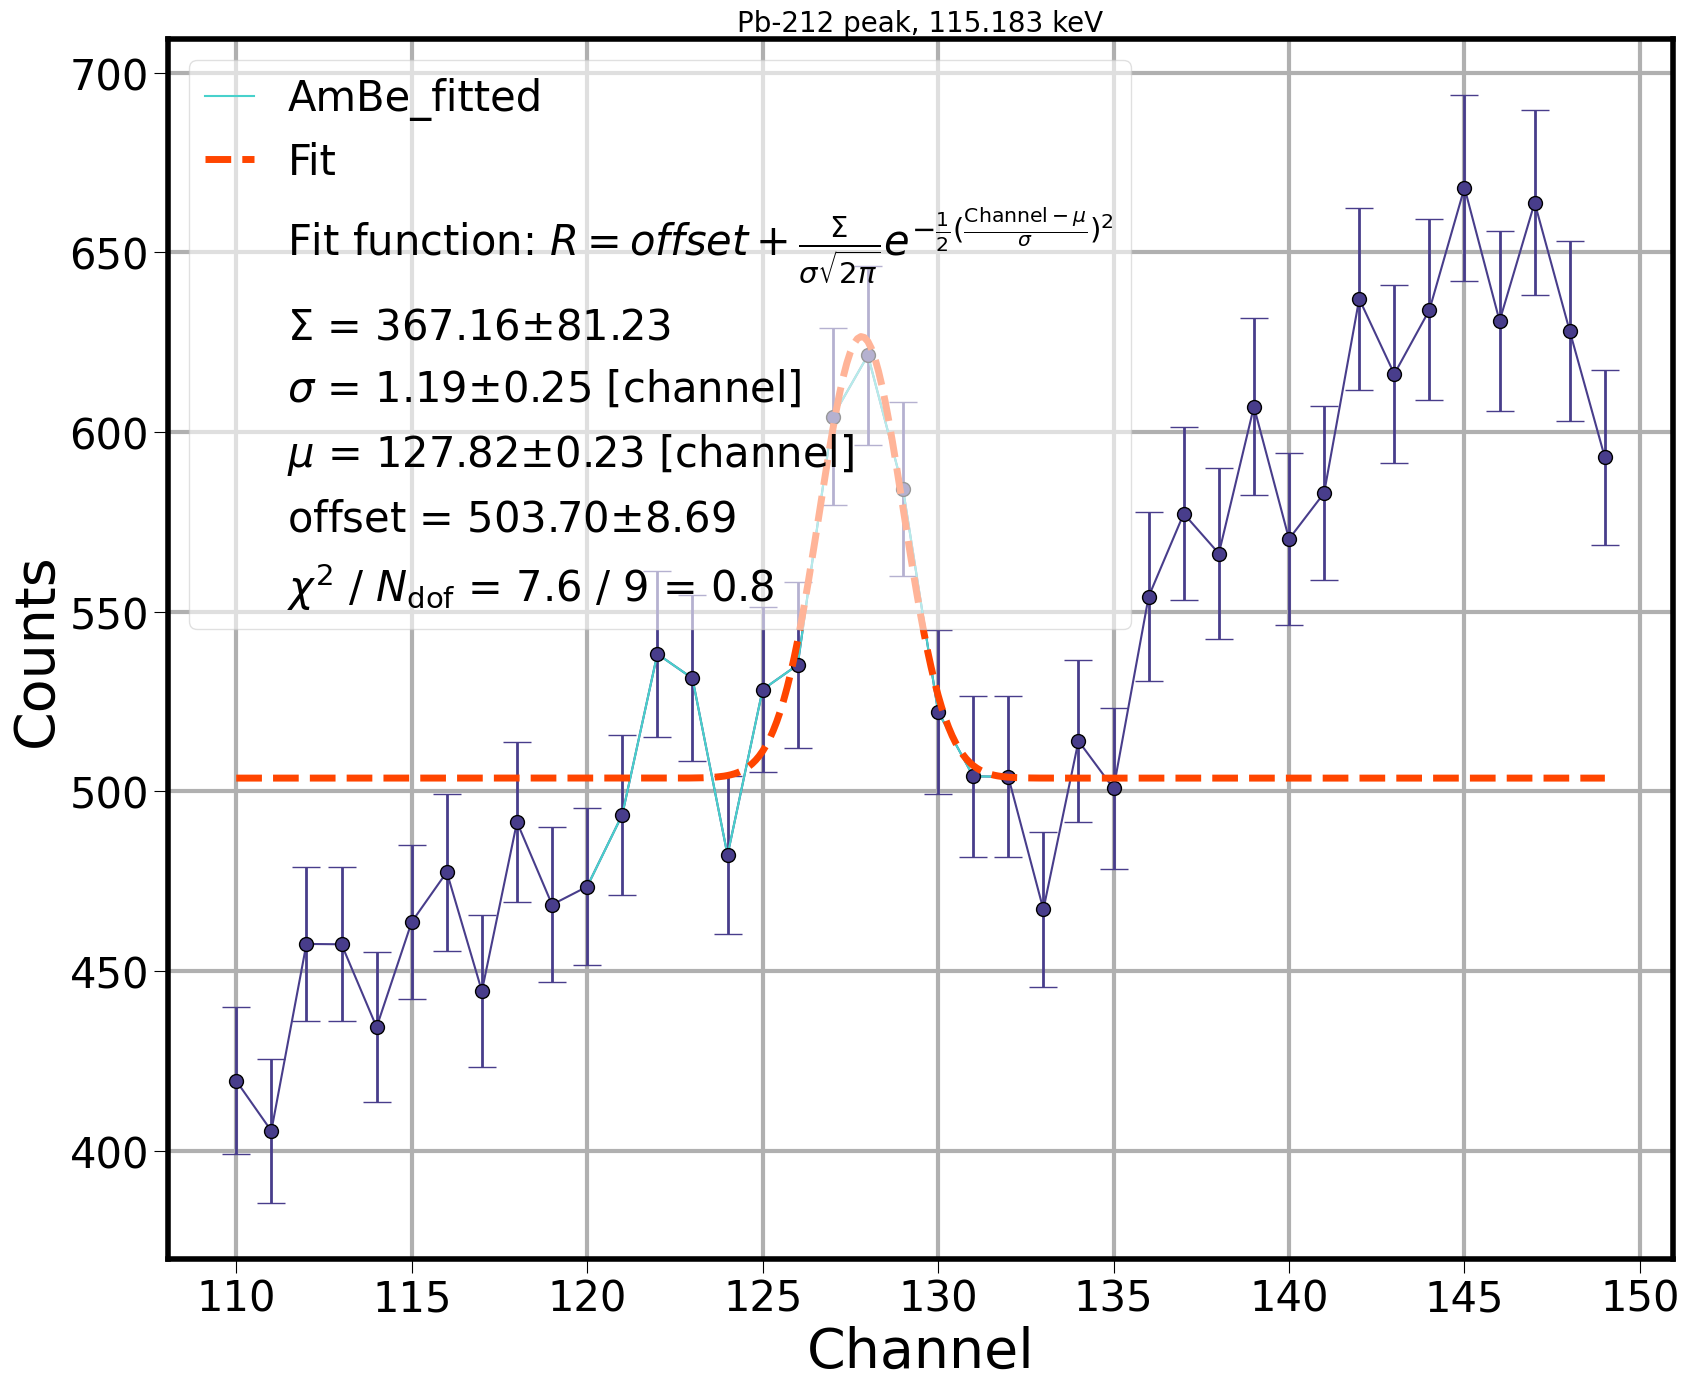

In [6]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()









ch1=120
ch2=133
ch3=110
ch4=150

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 127
sig00 = 5 
offset00 = 300

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 277.371 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.58 (χ²/ndof = 1.5)      │              Nfcn = 127              │
│ EDM = 1.54e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.25e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ sig    │   1.48    │   0.08    │            │            │         │         │       │
│ 2 │ mu     │  307.97   │   0.07    │            │            │         │         │       │
│ 3 │ offset │    188    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 4.59e+03    2.989    0.249     -223 │
│    sig │    2.989  0.00595    0.001   -0.199 │
│     mu │    0.249    0.001  0.00525   -0.017 │
│ offset │     -223   -0.199   -0.017     27.4 │
└────────┴─────────────────────────────────────┘

<ValueView A=1252.462645116106 sig=1.48339046569859 mu=307.971957125861 offset=187.91083251879968>
<ErrorView A=67.77443390780249 sig=0.07714510985899792 mu=0.0724582132364874 offset=5.23205546675585>
(1252.462645116106, 1.48339046569859, 307.971957125861, 187.91083251879968)


/tmp/ipykernel_5968/2306937815.py:214: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf344d1b10> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/2306937815.py:250: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/2306937815.py:257: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf344d1b10> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

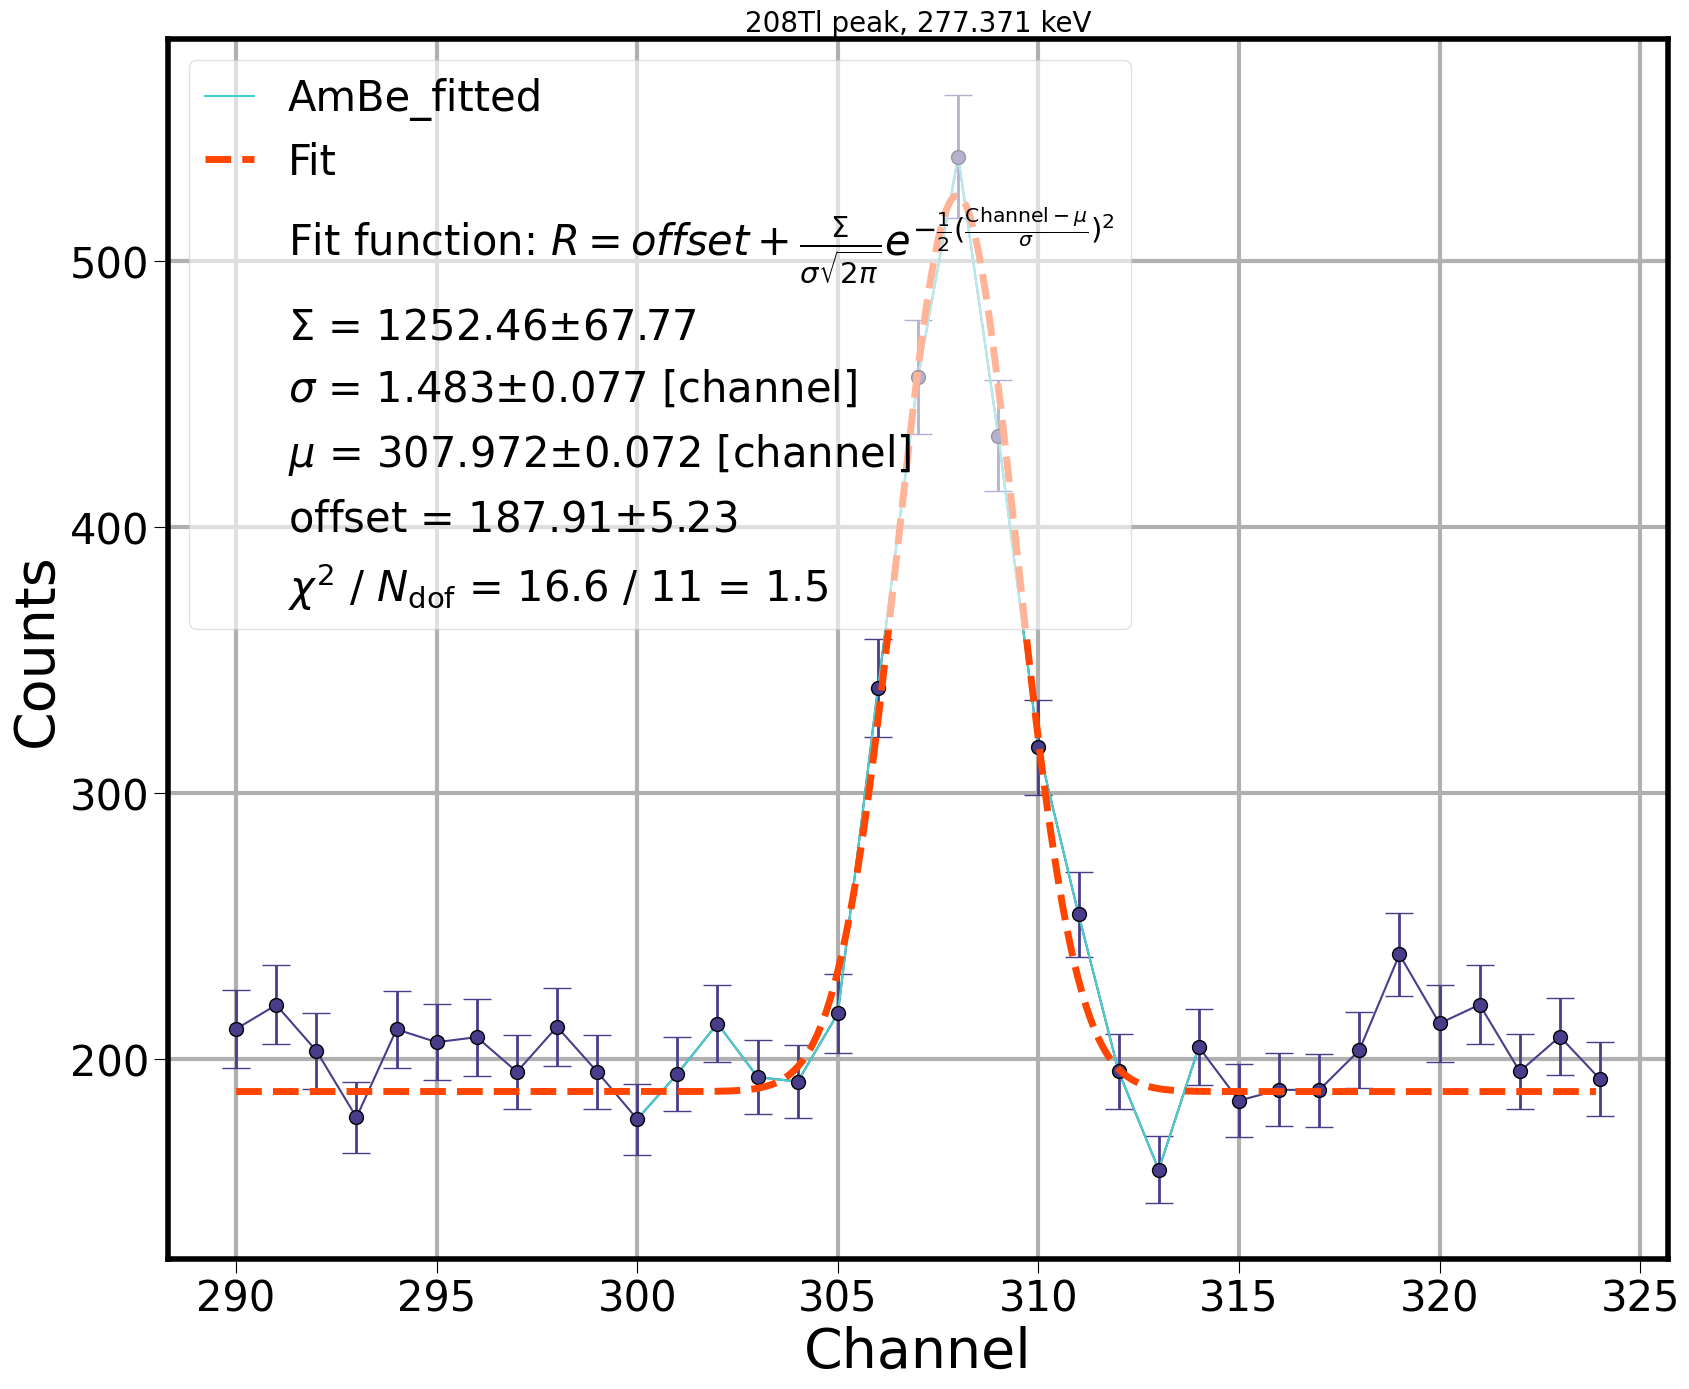

In [7]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()









ch1=300
ch2=315
ch3=290
ch4=325

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 307
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


In [8]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()









ch1=312
ch2=325
ch3=311
ch4=340

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 317
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 288.2 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.01 (χ²/ndof = 1.2)      │              Nfcn = 223              │
│ EDM = 1.72e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  0.19e3   │  0.11e3   │            │            │         │         │       │
│ 1 │ sig    │    1.9    │    1.0    │            │            │         │         │       │
│ 2 │ mu     │   319.9   │    0.6    │            │            │         │         │       │
│ 3 │ offset │    184    │     9     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 1.14e+04     94.3     29.2     -820 │
│    sig │     94.3     1.03      0.3     -6.7 │
│     mu │     29.2      0.3    0.389     -2.0 │
│ offset │     -820     -6.7     -2.0     73.6 │
└────────┴─────────────────────────────────────┘

<ValueView A=188.31838398107314 sig=1.9002197977283695 mu=319.9313726595933 offset=184.29183358268162>
<ErrorView A=106.97836701982362 sig=1.0165358477734054 mu=0.6234260846690467 offset=8.579638811247758>
(188.31838398107314, 1.9002197977283695, 319.9313726595933, 184.29183358268162)


/tmp/ipykernel_5968/3731102547.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf317df2e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/3731102547.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/3731102547.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf317df2e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Pb peak, 300.087 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.38 (χ²/ndof = 2.2)      │              Nfcn = 132              │
│ EDM = 1.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.70e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ sig    │   1.30    │   0.04    │            │            │         │         │       │
│ 2 │ mu     │  333.06   │   0.05    │            │            │         │         │       │
│ 3 │ offset │    176    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 4.07e+03   1.3025  -0.1190     -158 │
│    sig │   1.3025  0.00193  -0.0002  -0.0868 │
│     mu │  -0.1190  -0.0002  0.00236   0.0079 │
│ offset │     -158  -0.0868   0.0079     22.3 │
└────────┴─────────────────────────────────────┘

<ValueView A=1695.700142059428 sig=1.3008696795569468 mu=333.0640861669275 offset=176.02957912332417>
<ErrorView A=63.77081867845581 sig=0.04393241218417171 mu=0.048592160064096196 offset=4.719434377212635>
(1695.700142059428, 1.3008696795569468, 333.0640861669275, 176.02957912332417)


/tmp/ipykernel_5968/2687797449.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e204b50> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/2687797449.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/2687797449.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e204b50> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

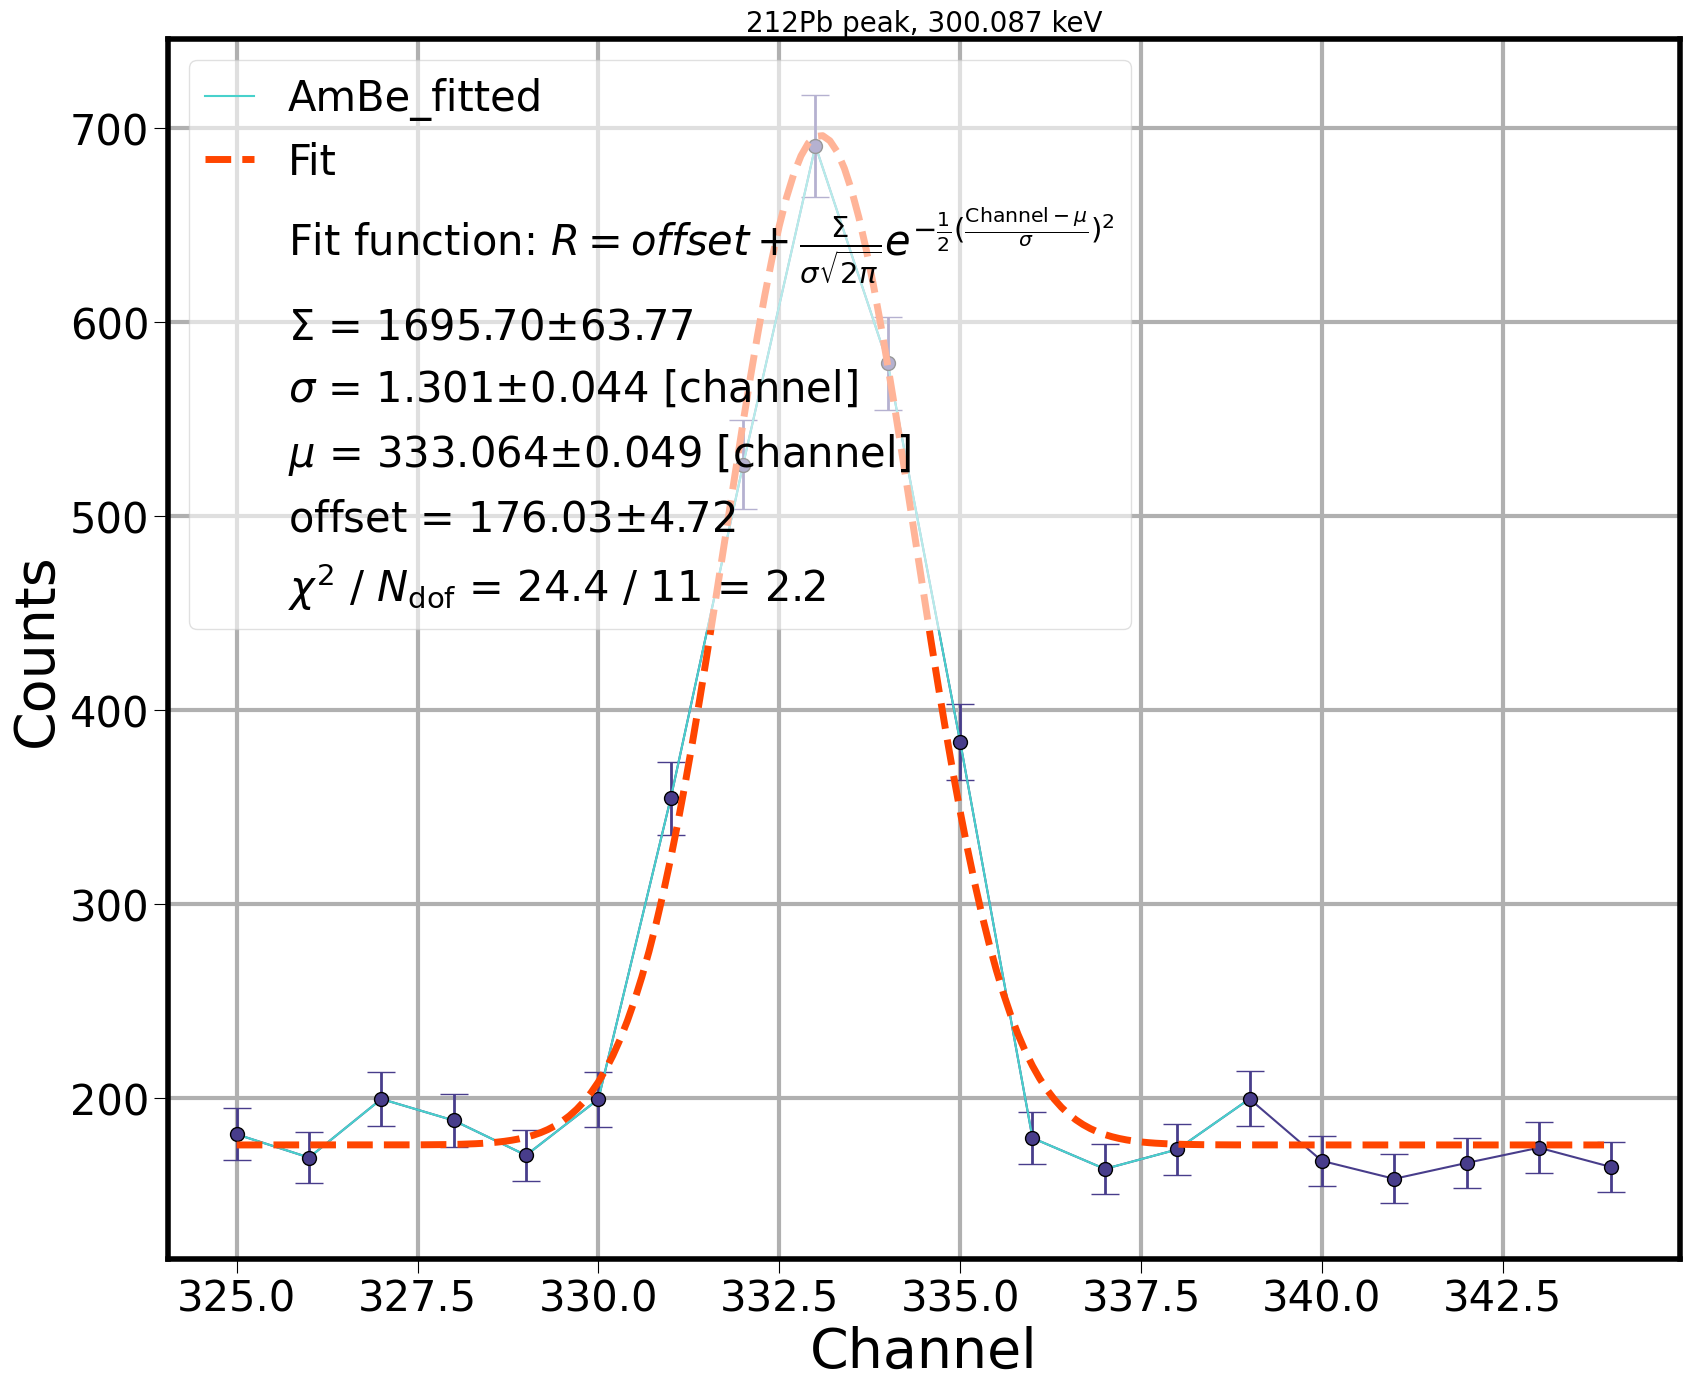

In [9]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=325
ch2=340
ch3=325
ch4=345

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 332
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 510.69 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 280.2 (χ²/ndof = 2.9)      │              Nfcn = 130              │
│ EDM = 1.27e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  3.76e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ sig    │   1.517   │   0.025   │            │            │         │         │       │
│ 2 │ mu     │  566.471  │   0.028   │            │            │         │         │       │
│ 3 │ offset │   59.1    │    0.8    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 4.34e+03 243.9e-3  -0.6e-3     -5.8 │
│    sig │ 243.9e-3 0.000608       -0  -2.4e-3 │
│     mu │  -0.6e-3       -0 0.000805        0 │
│ offset │     -5.8  -2.4e-3        0    0.649 │
└────────┴─────────────────────────────────────┘

<ValueView A=3760.5021854336596 sig=1.51680467155985 mu=566.4705008947592 offset=59.06500993394314>
<ErrorView A=65.88862144467868 sig=0.024650591581894116 mu=0.028373041938089726 offset=0.805430144346106>
(3760.5021854336596, 1.51680467155985, 566.4705008947592, 59.06500993394314)


/tmp/ipykernel_5968/1373025912.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31809a50> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/1373025912.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/1373025912.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31809a50> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

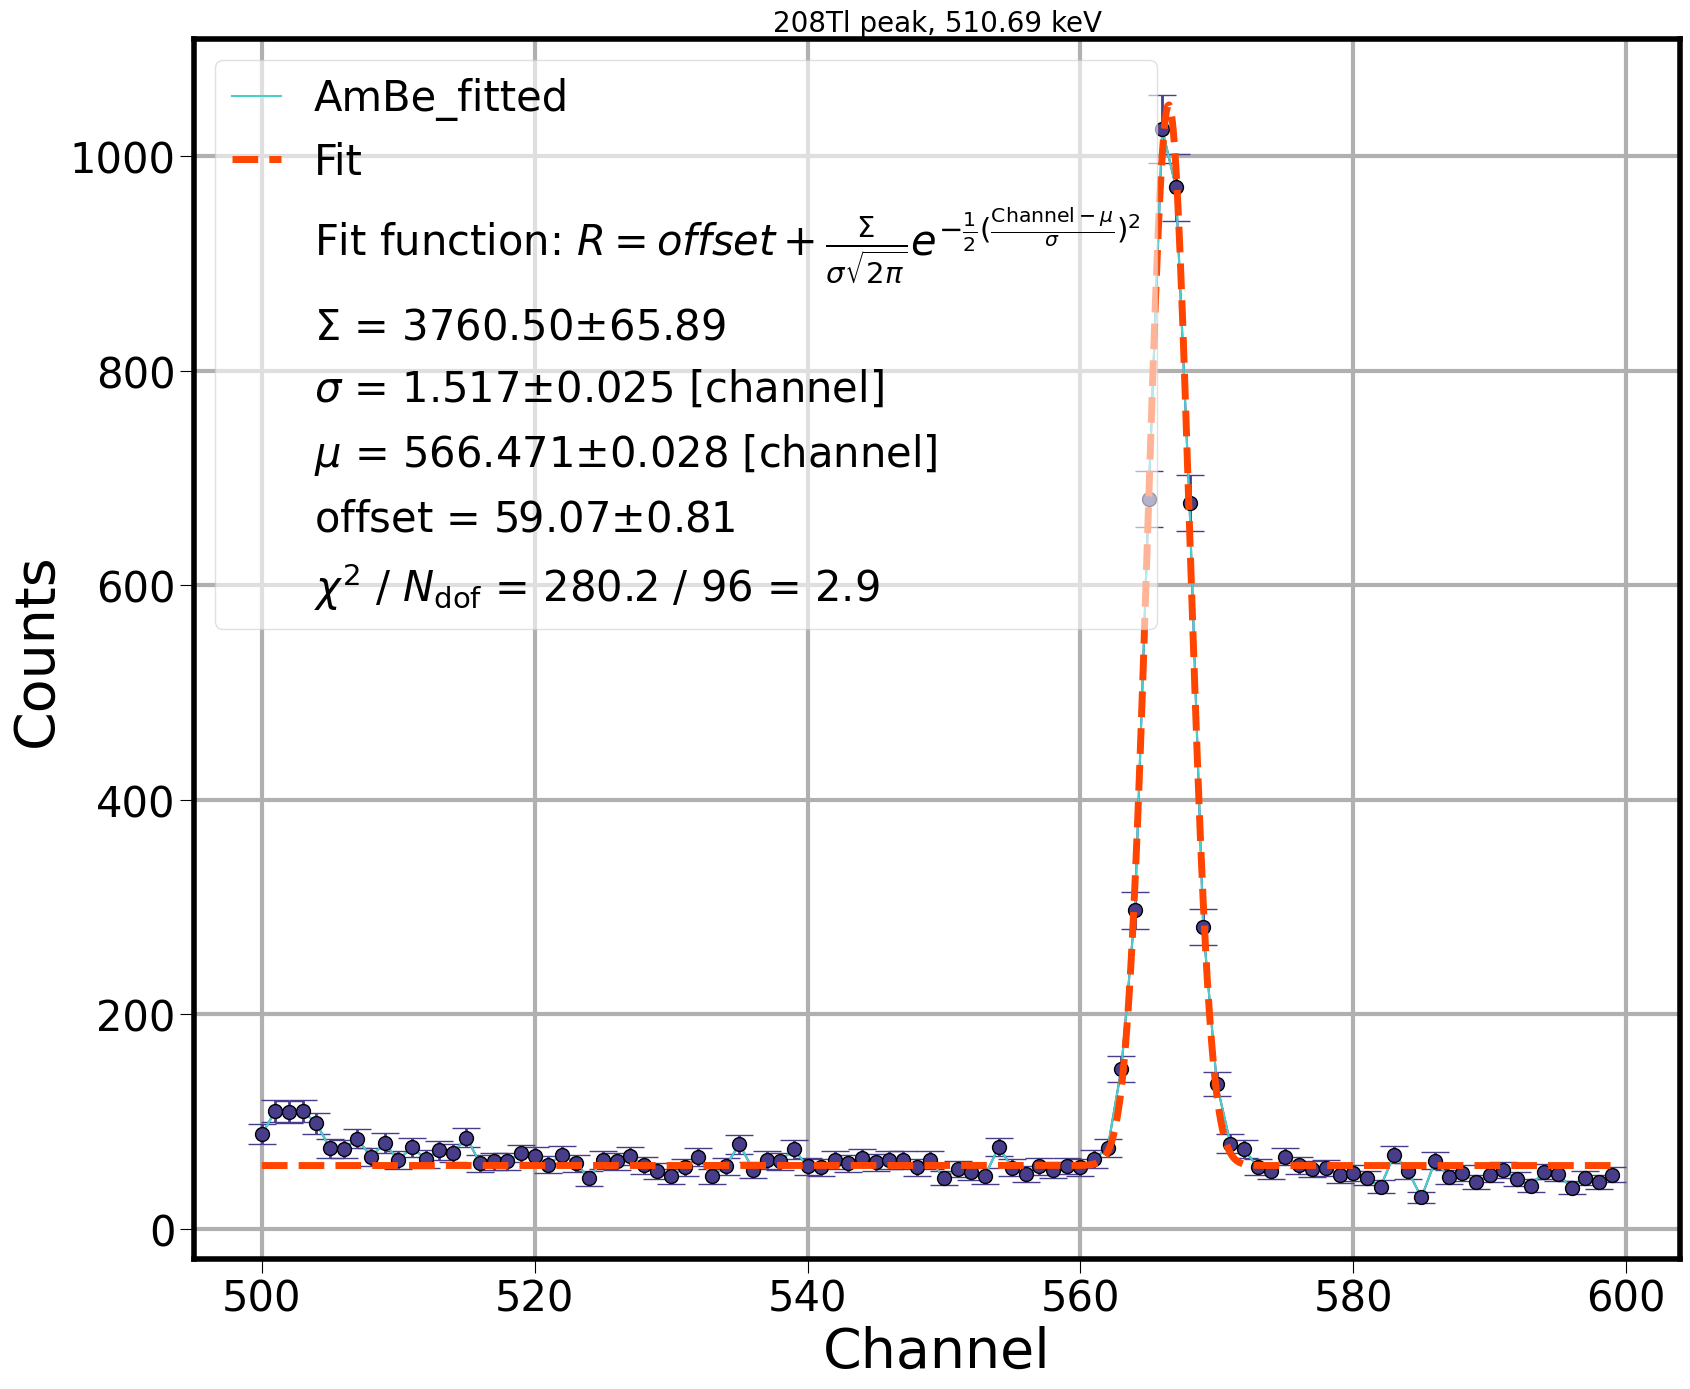

In [10]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=500
ch2=600
ch3=500
ch4=600

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 565
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 583.191 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 274.5 (χ²/ndof = 2.9)      │              Nfcn = 170              │
│ EDM = 8.35e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  10.75e3  │  0.10e3   │            │            │         │         │       │
│ 1 │ sig    │   1.415   │   0.011   │            │            │         │         │       │
│ 2 │ mu     │  646.676  │   0.014   │            │            │         │         │       │
│ 3 │ offset │   33.9    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 1.11e+04 59.00e-3 -1.84e-3     -3.4 │
│    sig │ 59.00e-3  0.00012       -0 -0.59e-3 │
│     mu │ -1.84e-3       -0 0.000203  0.02e-3 │
│ offset │     -3.4 -0.59e-3  0.02e-3    0.373 │
└────────┴─────────────────────────────────────┘

<ValueView A=10749.002403079072 sig=1.4145835004258926 mu=646.676299723071 offset=33.88074980518115>
<ErrorView A=105.31446732502229 sig=0.010966065960196303 mu=0.014257323837283056 offset=0.6107587746005174>
(10749.002403079072, 1.4145835004258926, 646.676299723071, 33.88074980518115)


/tmp/ipykernel_5968/730351164.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf317d5750> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/730351164.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/730351164.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf317d5750> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

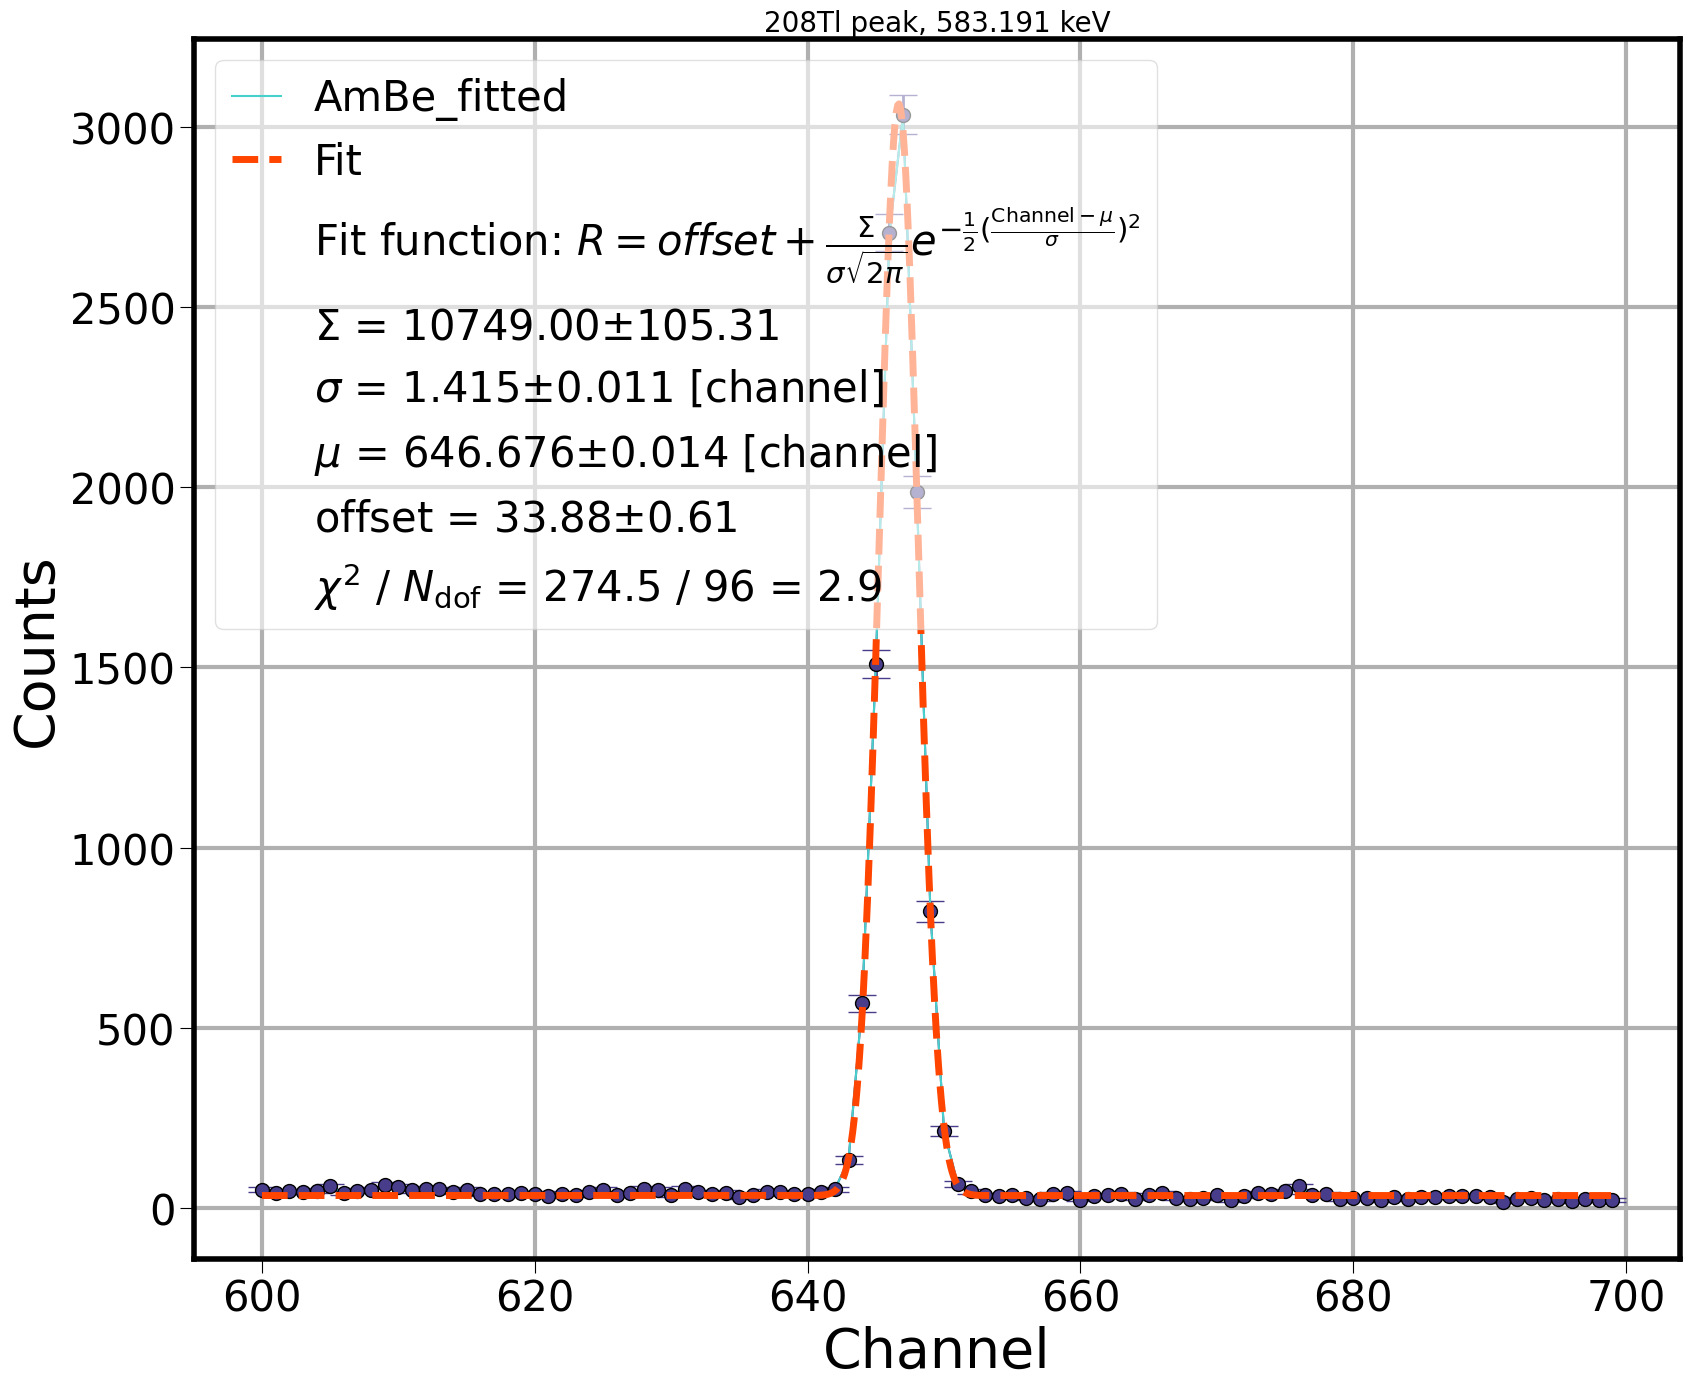

In [11]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=600
ch2=700
ch3=600
ch4=700

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 645
sig00 = 5 
offset00 = 100

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 727.33 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.32 (χ²/ndof = 1.4)      │              Nfcn = 106              │
│ EDM = 1.97e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  2.14e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ sig    │   1.443   │   0.027   │            │            │         │         │       │
│ 2 │ mu     │  806.258  │   0.034   │            │            │         │         │       │
│ 3 │ offset │   17.5    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 2.59e+03 115.1e-3   0.0032     -3.3 │
│    sig │ 115.1e-3 0.000734   0.1e-3  -2.8e-3 │
│     mu │   0.0032   0.1e-3  0.00119  -0.0003 │
│ offset │     -3.3  -2.8e-3  -0.0003    0.427 │
└────────┴─────────────────────────────────────┘

<ValueView A=2143.7793025060696 sig=1.4428722819255424 mu=806.2575507885267 offset=17.4740519971807>
<ErrorView A=50.91652650629659 sig=0.027090058682486623 mu=0.03450988281988982 offset=0.6536368028066277>
(2143.7793025060696, 1.4428722819255424, 806.2575507885267, 17.4740519971807)


/tmp/ipykernel_5968/4084627072.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31869600> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/4084627072.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/4084627072.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31869600> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

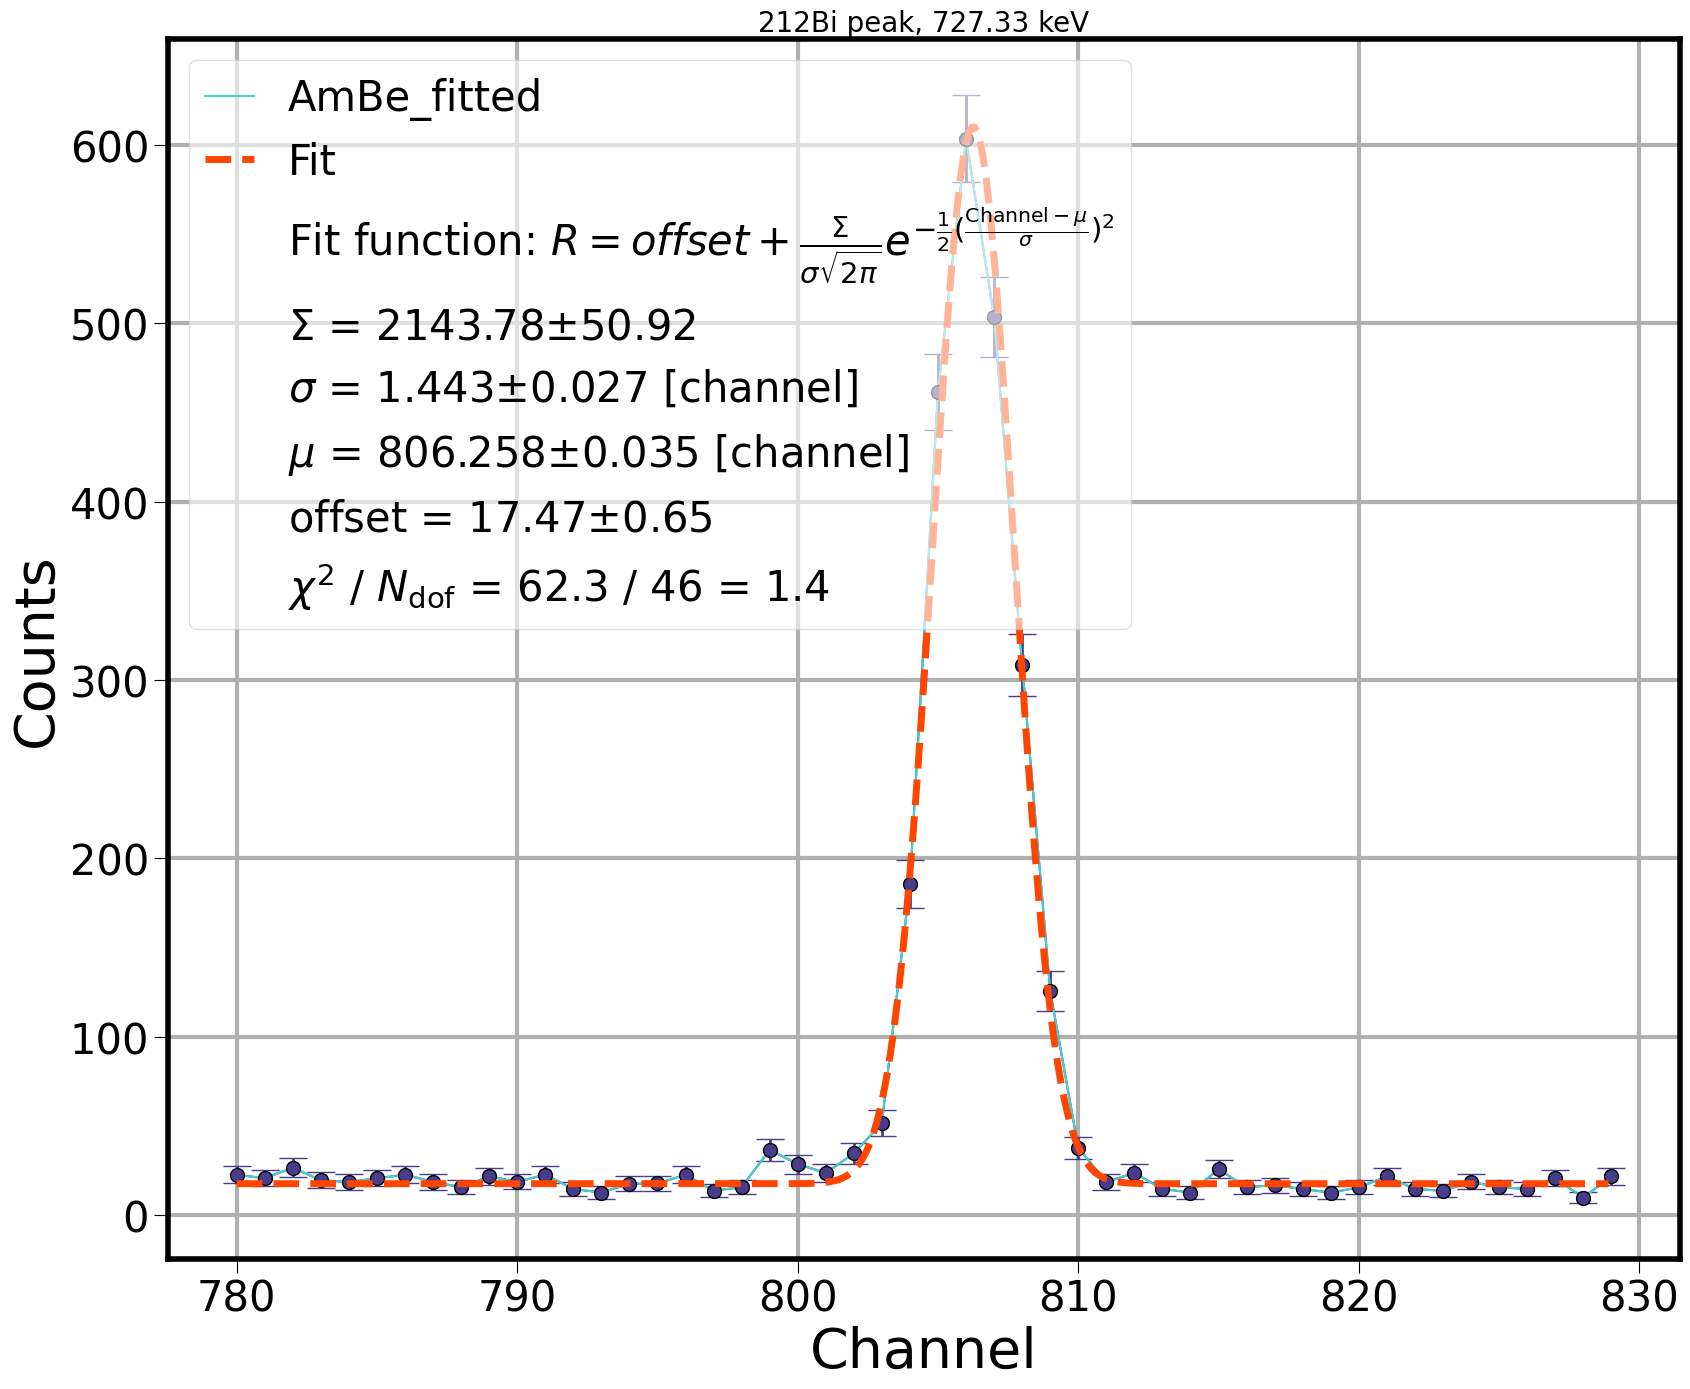

In [12]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=780
ch2=830
ch3=780
ch4=830

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 805
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 763.13 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26.8 (χ²/ndof = 1.0)       │              Nfcn = 129              │
│ EDM = 3.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    183    │    20     │            │            │         │         │       │
│ 1 │ sig    │   1.55    │   0.15    │            │            │         │         │       │
│ 2 │ mu     │  846.22   │   0.18    │            │            │         │         │       │
│ 3 │ offset │   16.7    │    0.9    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    379  1.177 -0.155   -6.5 │
│    sig │  1.177 0.0235 -0.004 -0.039 │
│     mu │ -0.155 -0.004 0.0318  0.005 │
│ offset │   -6.5 -0.039  0.005  0.775 │
└────────┴─────────────────────────────┘

<ValueView A=183.42103161093456 sig=1.5460411191232042 mu=846.2168693057446 offset=16.726075068151957>
<ErrorView A=19.477004969628627 sig=0.15341557709499662 mu=0.17818926630221196 offset=0.8805085032760323>
(183.42103161093456, 1.5460411191232042, 846.2168693057446, 16.726075068151957)


/tmp/ipykernel_5968/1502021835.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2ec294e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/1502021835.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/1502021835.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2ec294e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

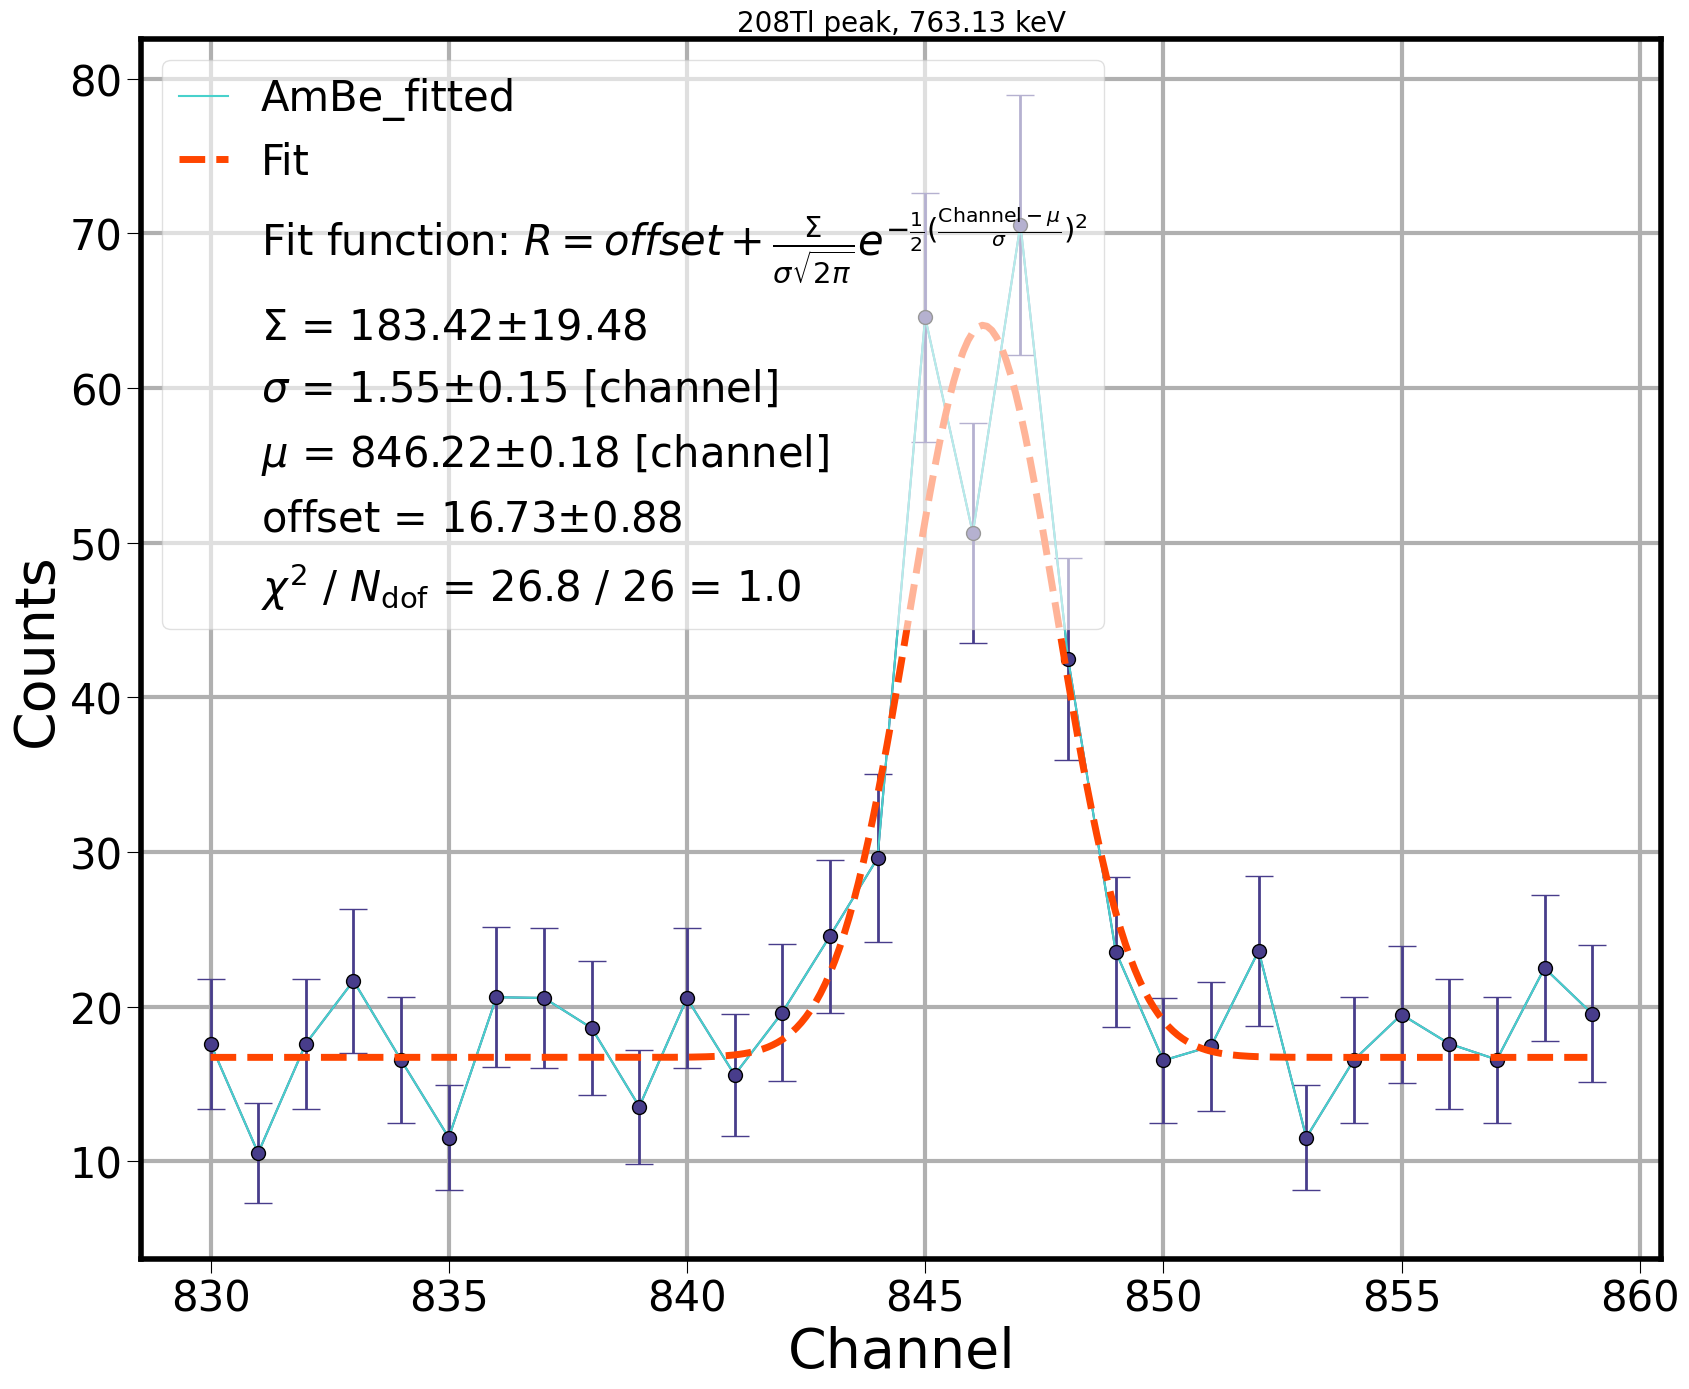

In [13]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=830
ch2=860
ch3=830
ch4=860

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 200
mu00 = 844
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 785.37 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.843 (χ²/ndof = 0.6)      │              Nfcn = 224              │
│ EDM = 1.97e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    374    │    24     │            │            │         │         │       │
│ 1 │ sig    │   1.48    │   0.09    │            │            │         │         │       │
│ 2 │ mu     │  870.69   │   0.10    │            │            │         │         │       │
│ 3 │ offset │   13.5    │    1.1    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │     575   0.703   0.036   -10.0 │
│    sig │   0.703 0.00813   0.001  -0.035 │
│     mu │   0.036   0.001 0.00952  -0.002 │
│ offset │   -10.0  -0.035  -0.002    1.18 │
└────────┴─────────────────────────────────┘

<ValueView A=374.27485914689595 sig=1.4840099973836618 mu=870.6937751366899 offset=13.541359821470147>
<ErrorView A=23.97348154880137 sig=0.09018236583006661 mu=0.09758771961138243 offset=1.085410073532264>
(374.27485914689595, 1.4840099973836618, 870.6937751366899, 13.541359821470147)


/tmp/ipykernel_5968/2271583339.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e1b34c0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/2271583339.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/2271583339.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e1b34c0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

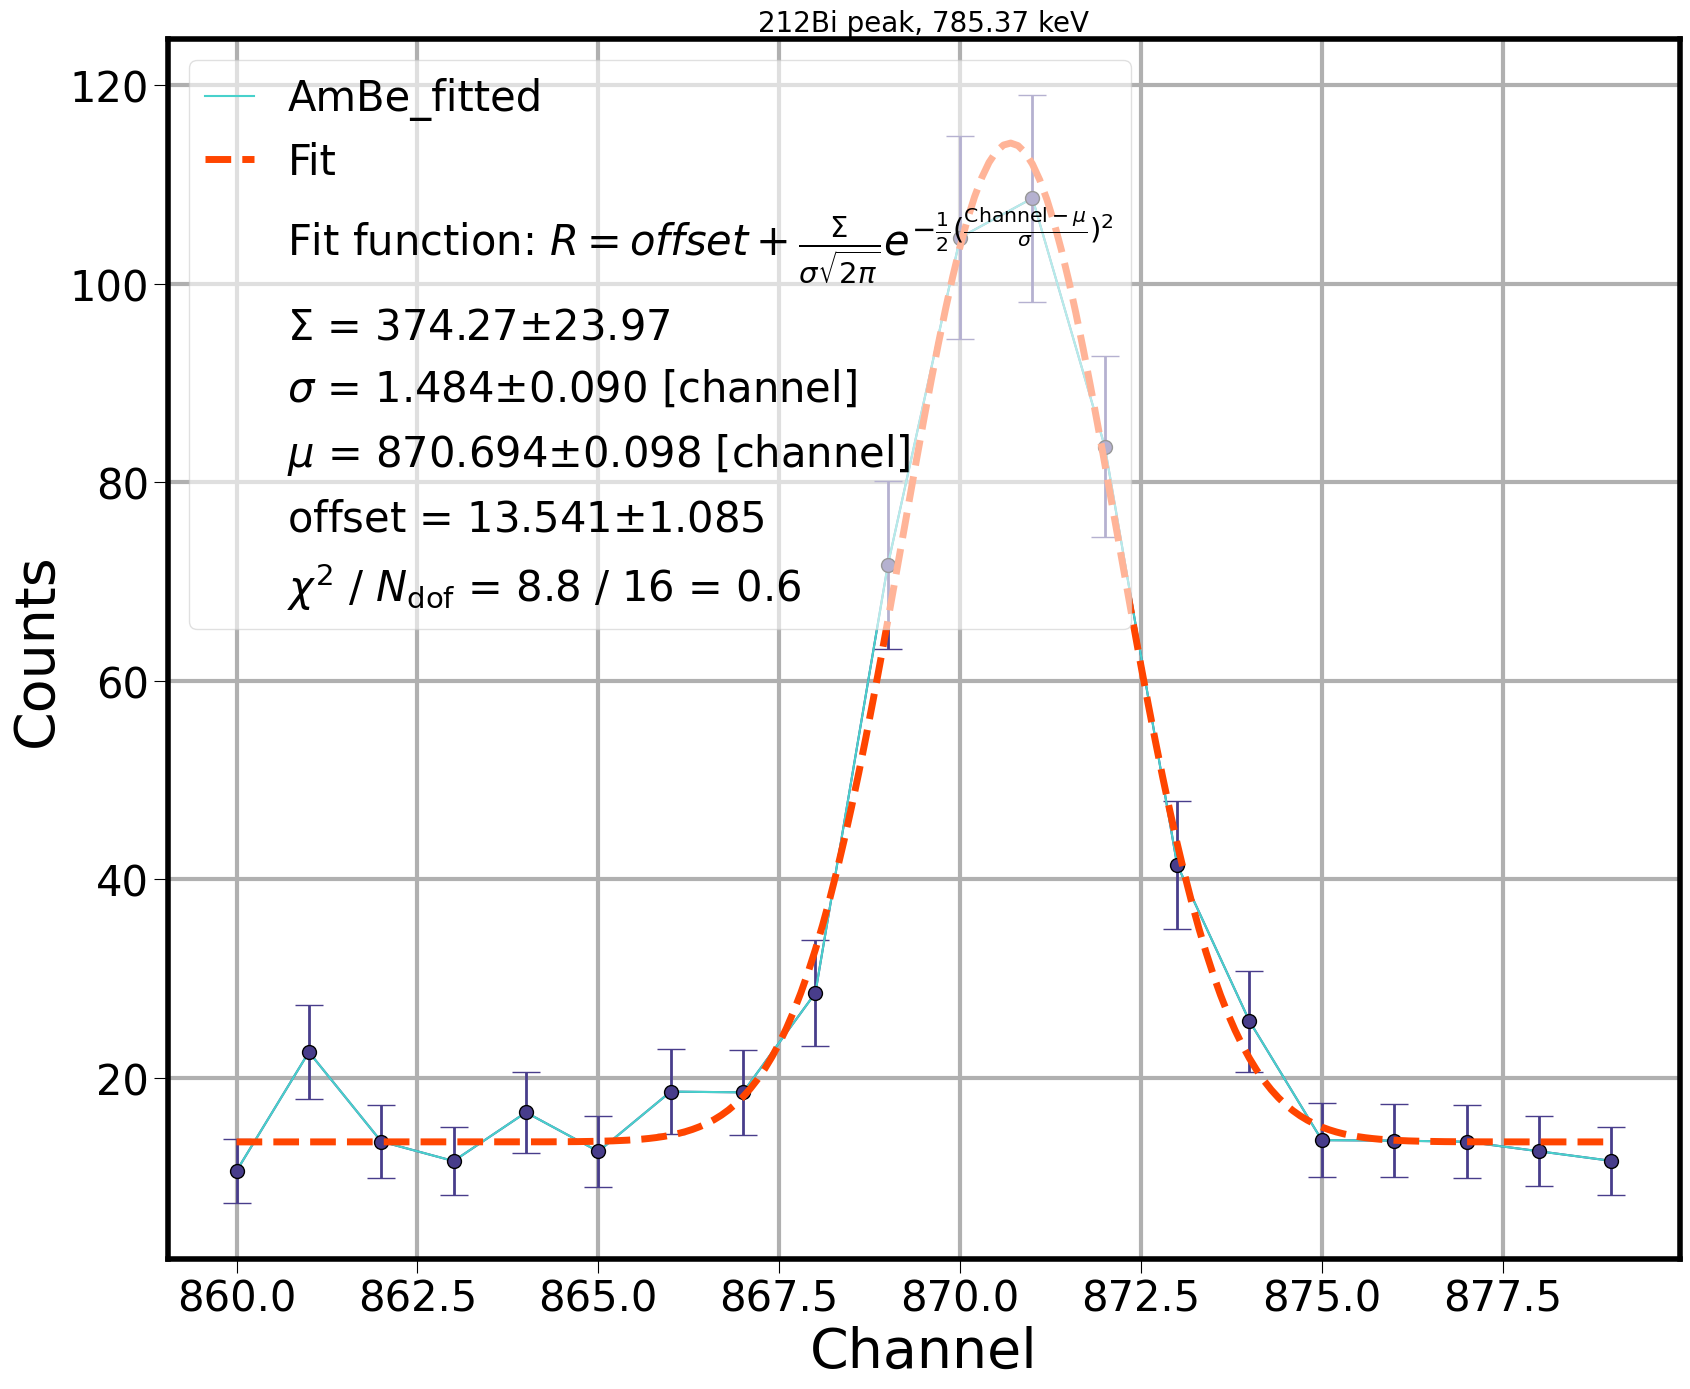

In [14]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=860
ch2=880
ch3=860
ch4=880

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 867
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 860.564 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.91 (χ²/ndof = 1.1)      │              Nfcn = 176              │
│ EDM = 5.28e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.35e3   │  0.04e3   │            │            │         │         │       │
│ 1 │ sig    │   1.48    │   0.04    │            │            │         │         │       │
│ 2 │ mu     │  953.72   │   0.04    │            │            │         │         │       │
│ 3 │ offset │   12.7    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │ 1.5e+03  0.1772 -0.0049    -3.7 │
│    sig │  0.1772 0.00132 -0.0001 -0.0044 │
│     mu │ -0.0049 -0.0001 0.00198  0.0001 │
│ offset │    -3.7 -0.0044  0.0001    0.41 │
└────────┴─────────────────────────────────┘

<ValueView A=1350.090291850542 sig=1.4792837334766666 mu=953.7208918346173 offset=12.706002082854765>
<ErrorView A=38.71531064623927 sig=0.03631263093641414 mu=0.04449931799864277 offset=0.6406570672224482>
(1350.090291850542, 1.4792837334766666, 953.7208918346173, 12.706002082854765)


/tmp/ipykernel_5968/321130902.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf3191e980> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/321130902.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/321130902.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf3191e980> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

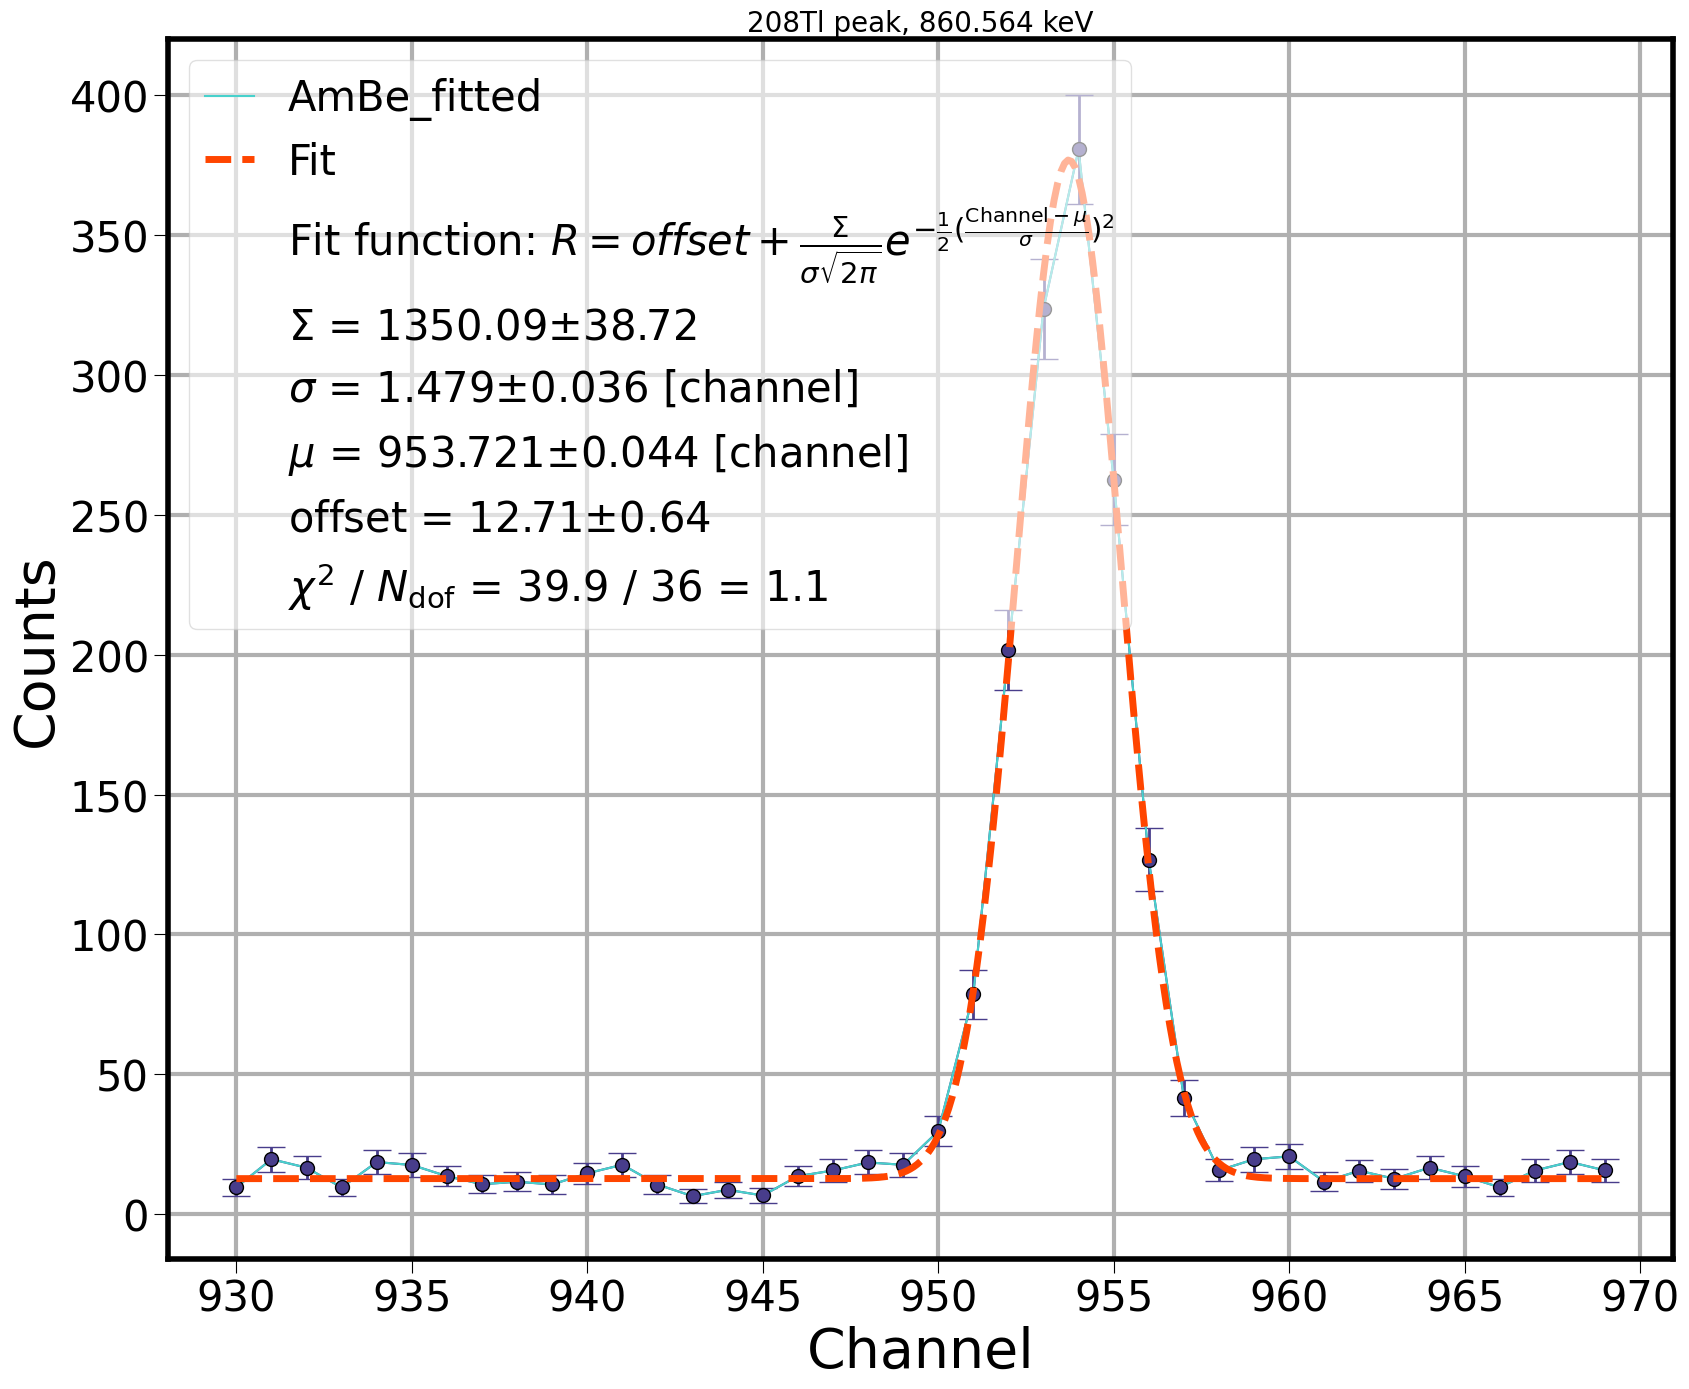

In [15]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=930
ch2=970
ch3=930
ch4=970

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 950
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 893.408 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.78 (χ²/ndof = 1.2)      │              Nfcn = 118              │
│ EDM = 1.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    82     │    13     │            │            │         │         │       │
│ 1 │ sig    │   1.18    │   0.22    │            │            │         │         │       │
│ 2 │ mu     │  990.16   │   0.22    │            │            │         │         │       │
│ 3 │ offset │   11.0    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    178   1.23   0.32   -3.2 │
│    sig │   1.23 0.0471   0.02  -0.04 │
│     mu │   0.32   0.02 0.0471  -0.01 │
│ offset │   -3.2  -0.04  -0.01  0.473 │
└────────┴─────────────────────────────┘

<ValueView A=81.58965023253587 sig=1.1845377028720312 mu=990.161152005683 offset=10.993717258604574>
<ErrorView A=13.331871448750393 sig=0.21702664556025886 mu=0.21700191025466517 offset=0.6880317330420559>
(81.58965023253587, 1.1845377028720312, 990.161152005683, 10.993717258604574)


/tmp/ipykernel_5968/2043518579.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e1679a0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/2043518579.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/2043518579.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e1679a0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

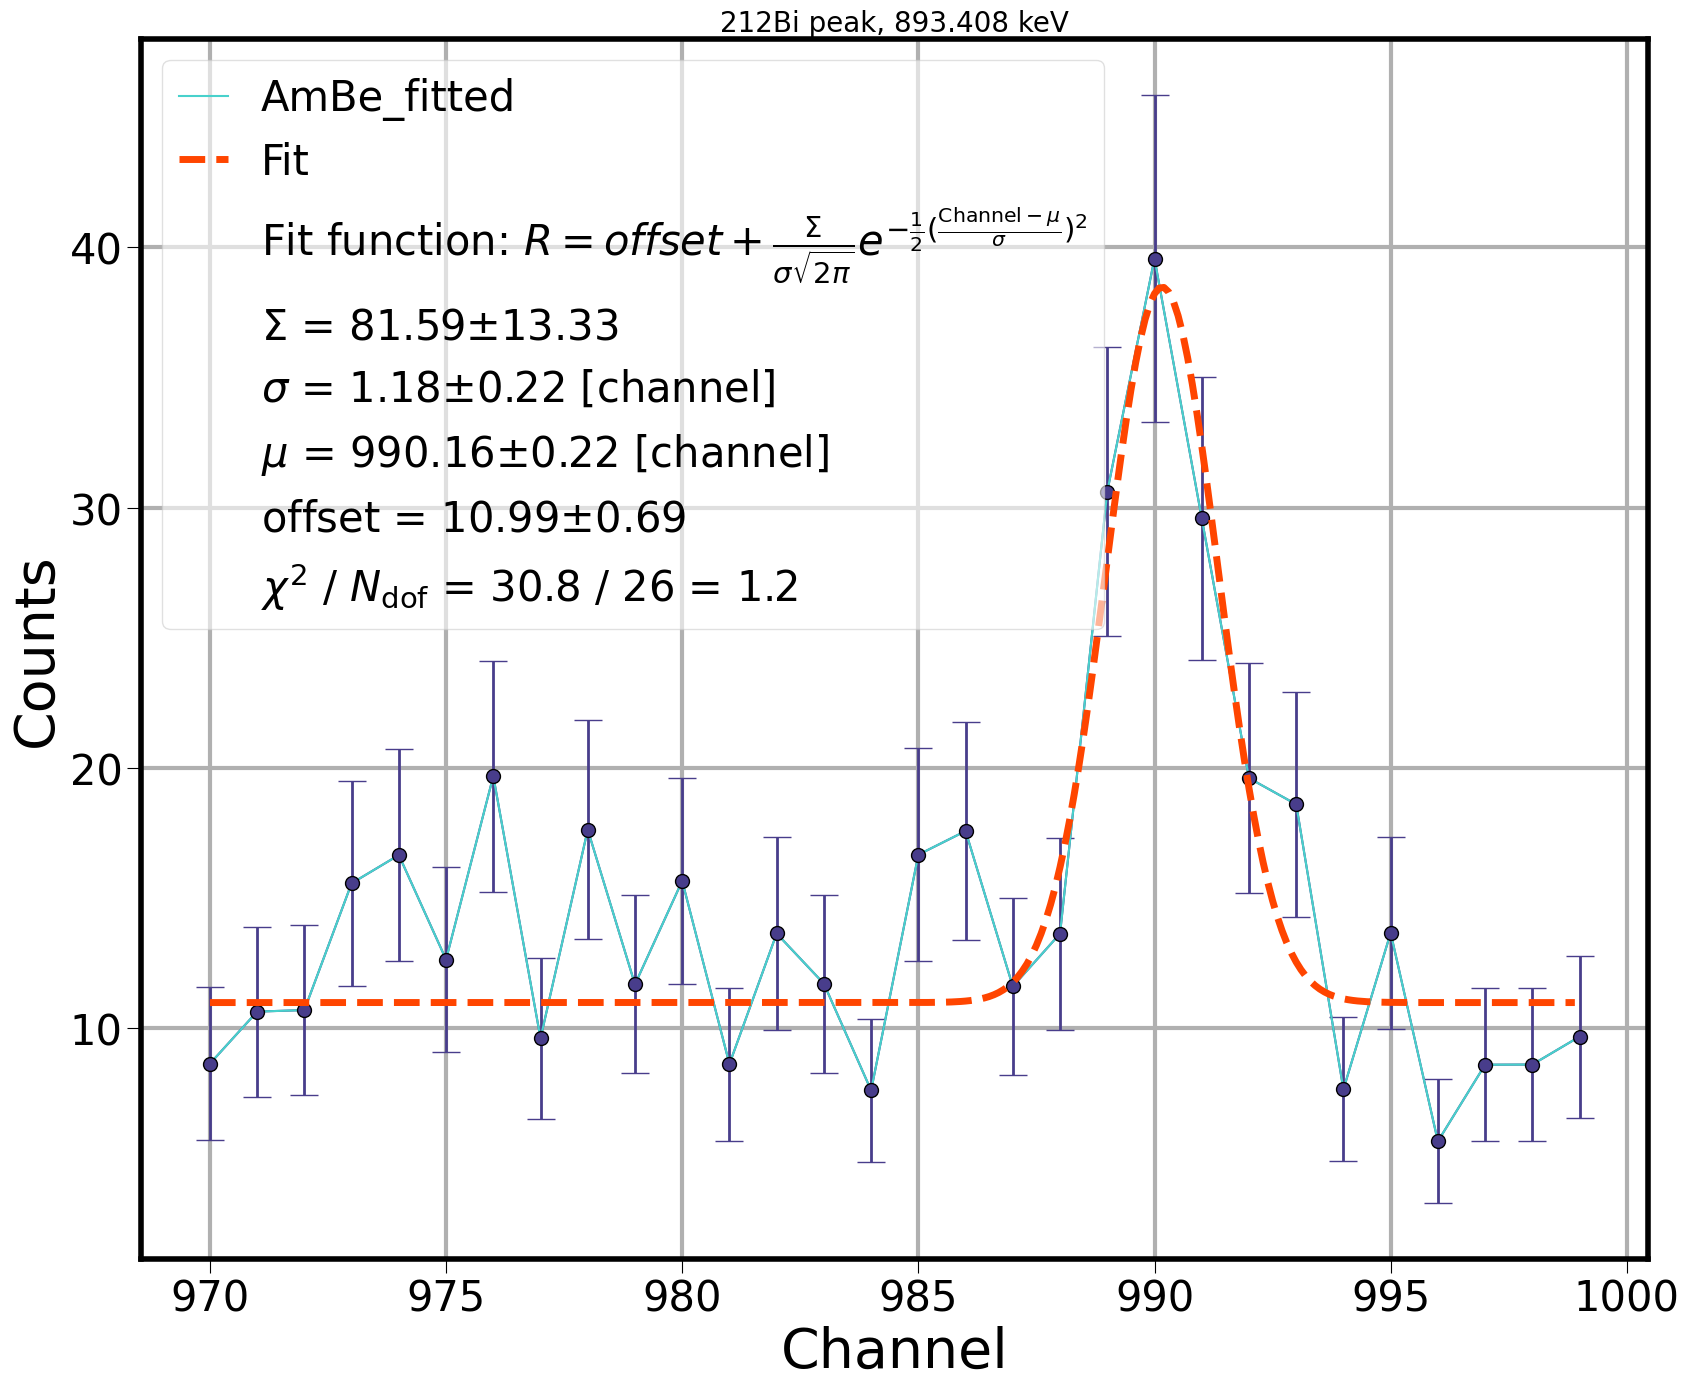

In [16]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=970
ch2=1000
ch3=970
ch4=1000

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 40
mu00 = 990
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1078.62 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.34 (χ²/ndof = 2.1)      │              Nfcn = 155              │
│ EDM = 8.09e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    140    │    15     │            │            │         │         │       │
│ 1 │ sig    │   1.40    │   0.15    │            │            │         │         │       │
│ 2 │ mu     │ 1.19532e3 │ 0.00015e3 │            │            │         │         │       │
│ 3 │ offset │    6.1    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    215  0.725  0.059   -3.0 │
│    sig │  0.725 0.0233  0.003 -0.029 │
│     mu │  0.059  0.003 0.0238 -0.002 │
│ offset │   -3.0 -0.029 -0.002  0.365 │
└────────┴─────────────────────────────┘

<ValueView A=140.19599912742558 sig=1.4047453861230763 mu=1195.3163506114909 offset=6.144892897697182>
<ErrorView A=14.656787487727032 sig=0.15268709875712191 mu=0.15419398196170528 offset=0.6043564528595183>
(140.19599912742558, 1.4047453861230763, 1195.3163506114909, 6.144892897697182)


/tmp/ipykernel_5968/586977624.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf317d76d0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/586977624.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/586977624.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf317d76d0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

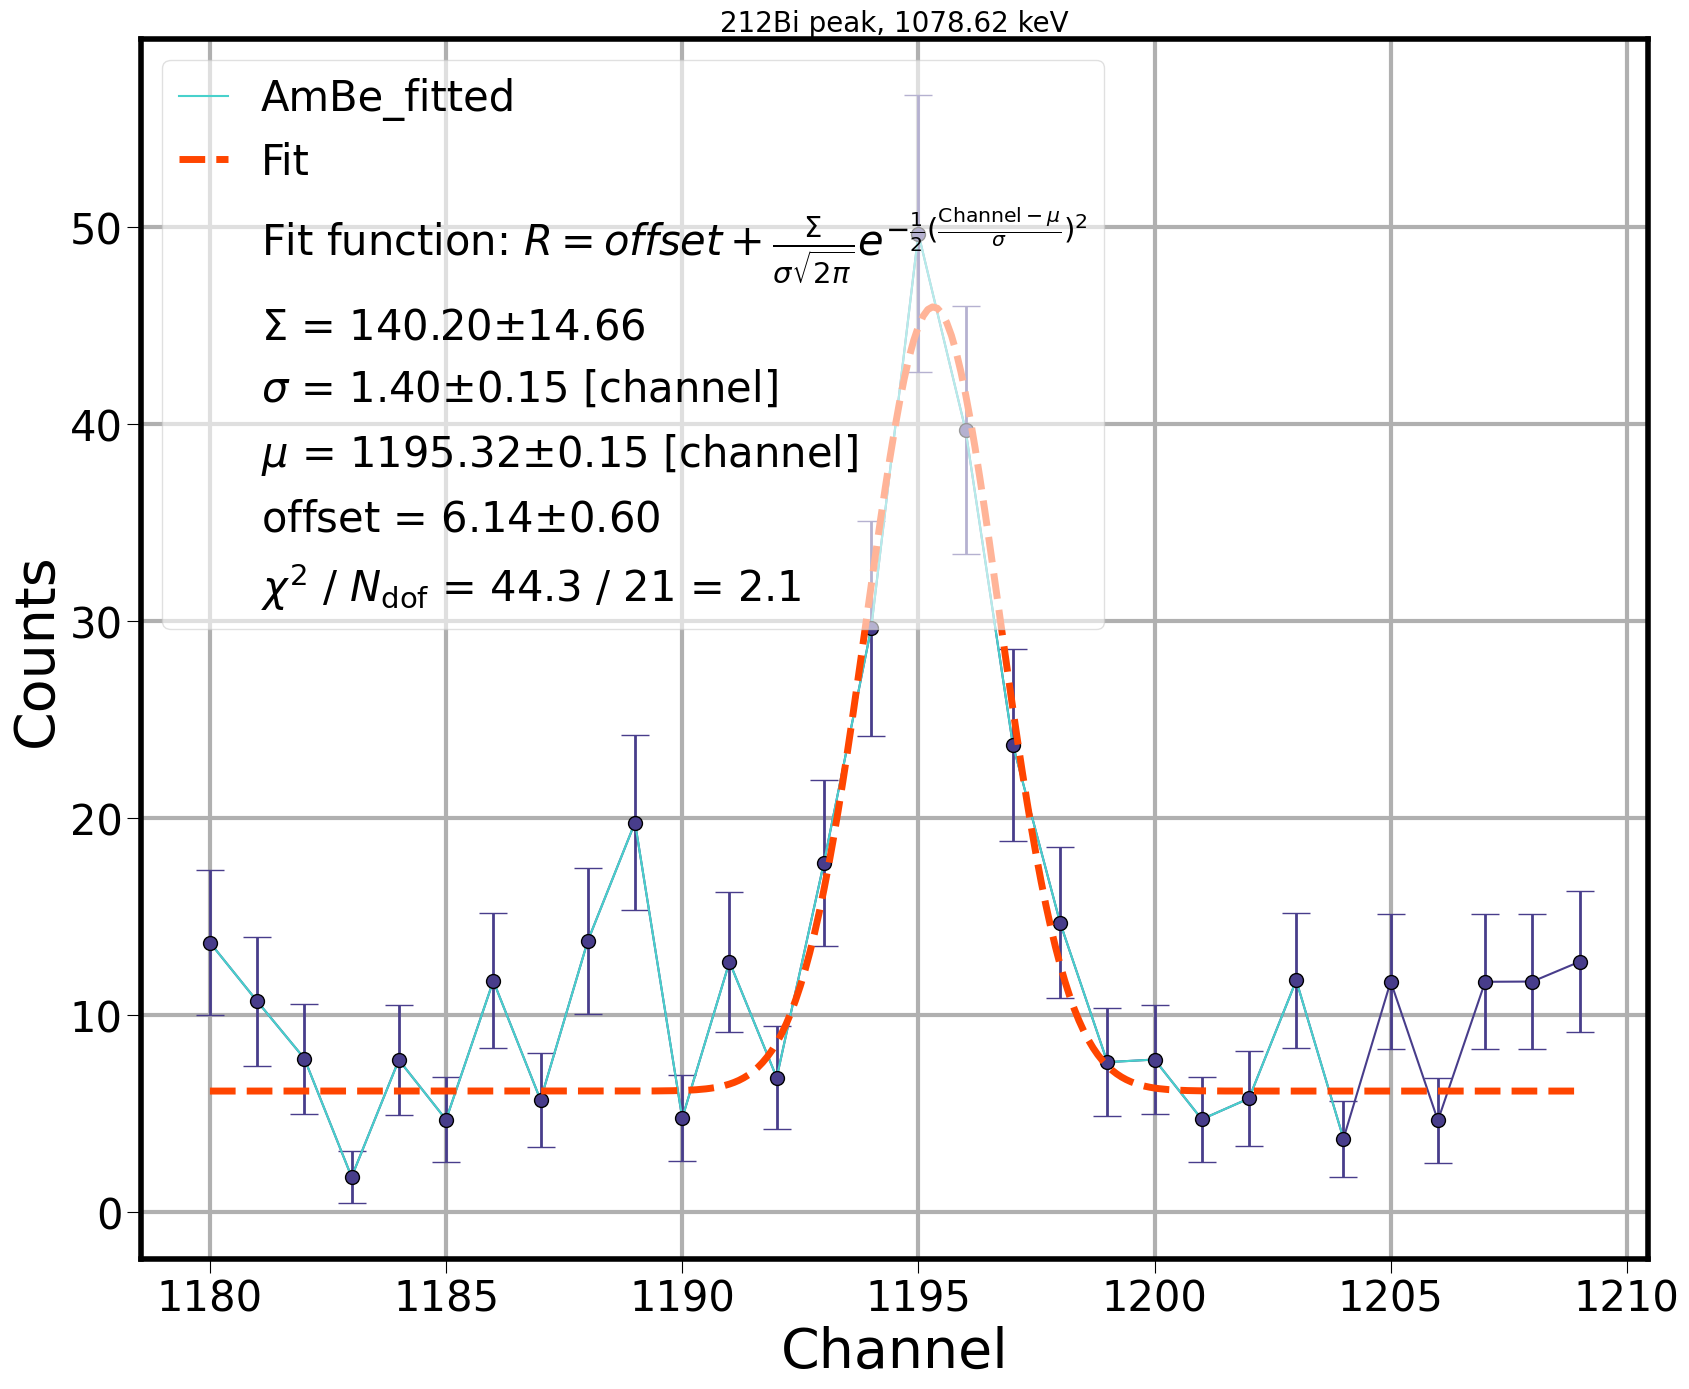

In [17]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1180
ch2=1205
ch3=1180
ch4=1210

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1200
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1093.9 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 41.2 (χ²/ndof = 1.6)       │              Nfcn = 214              │
│ EDM = 8.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    48     │    15     │            │            │         │         │       │
│ 1 │ sig    │    2.4    │    0.9    │            │            │         │         │       │
│ 2 │ mu     │ 1.2116e3  │ 0.0007e3  │            │            │         │         │       │
│ 3 │ offset │    6.8    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    235    8.9   -0.5   -6.2 │
│    sig │    8.9  0.833   -0.1   -0.3 │
│     mu │   -0.5   -0.1  0.427    0.0 │
│ offset │   -6.2   -0.3    0.0  0.434 │
└────────┴─────────────────────────────┘

<ValueView A=48.48919119259893 sig=2.382465414516428 mu=1211.5766940067838 offset=6.773455889018029>
<ErrorView A=15.34234950623047 sig=0.912699942094781 mu=0.6536539509952553 offset=0.6584783970111138>
(48.48919119259893, 2.382465414516428, 1211.5766940067838, 6.773455889018029)


/tmp/ipykernel_5968/559540554.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31951ea0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/559540554.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/559540554.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31951ea0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

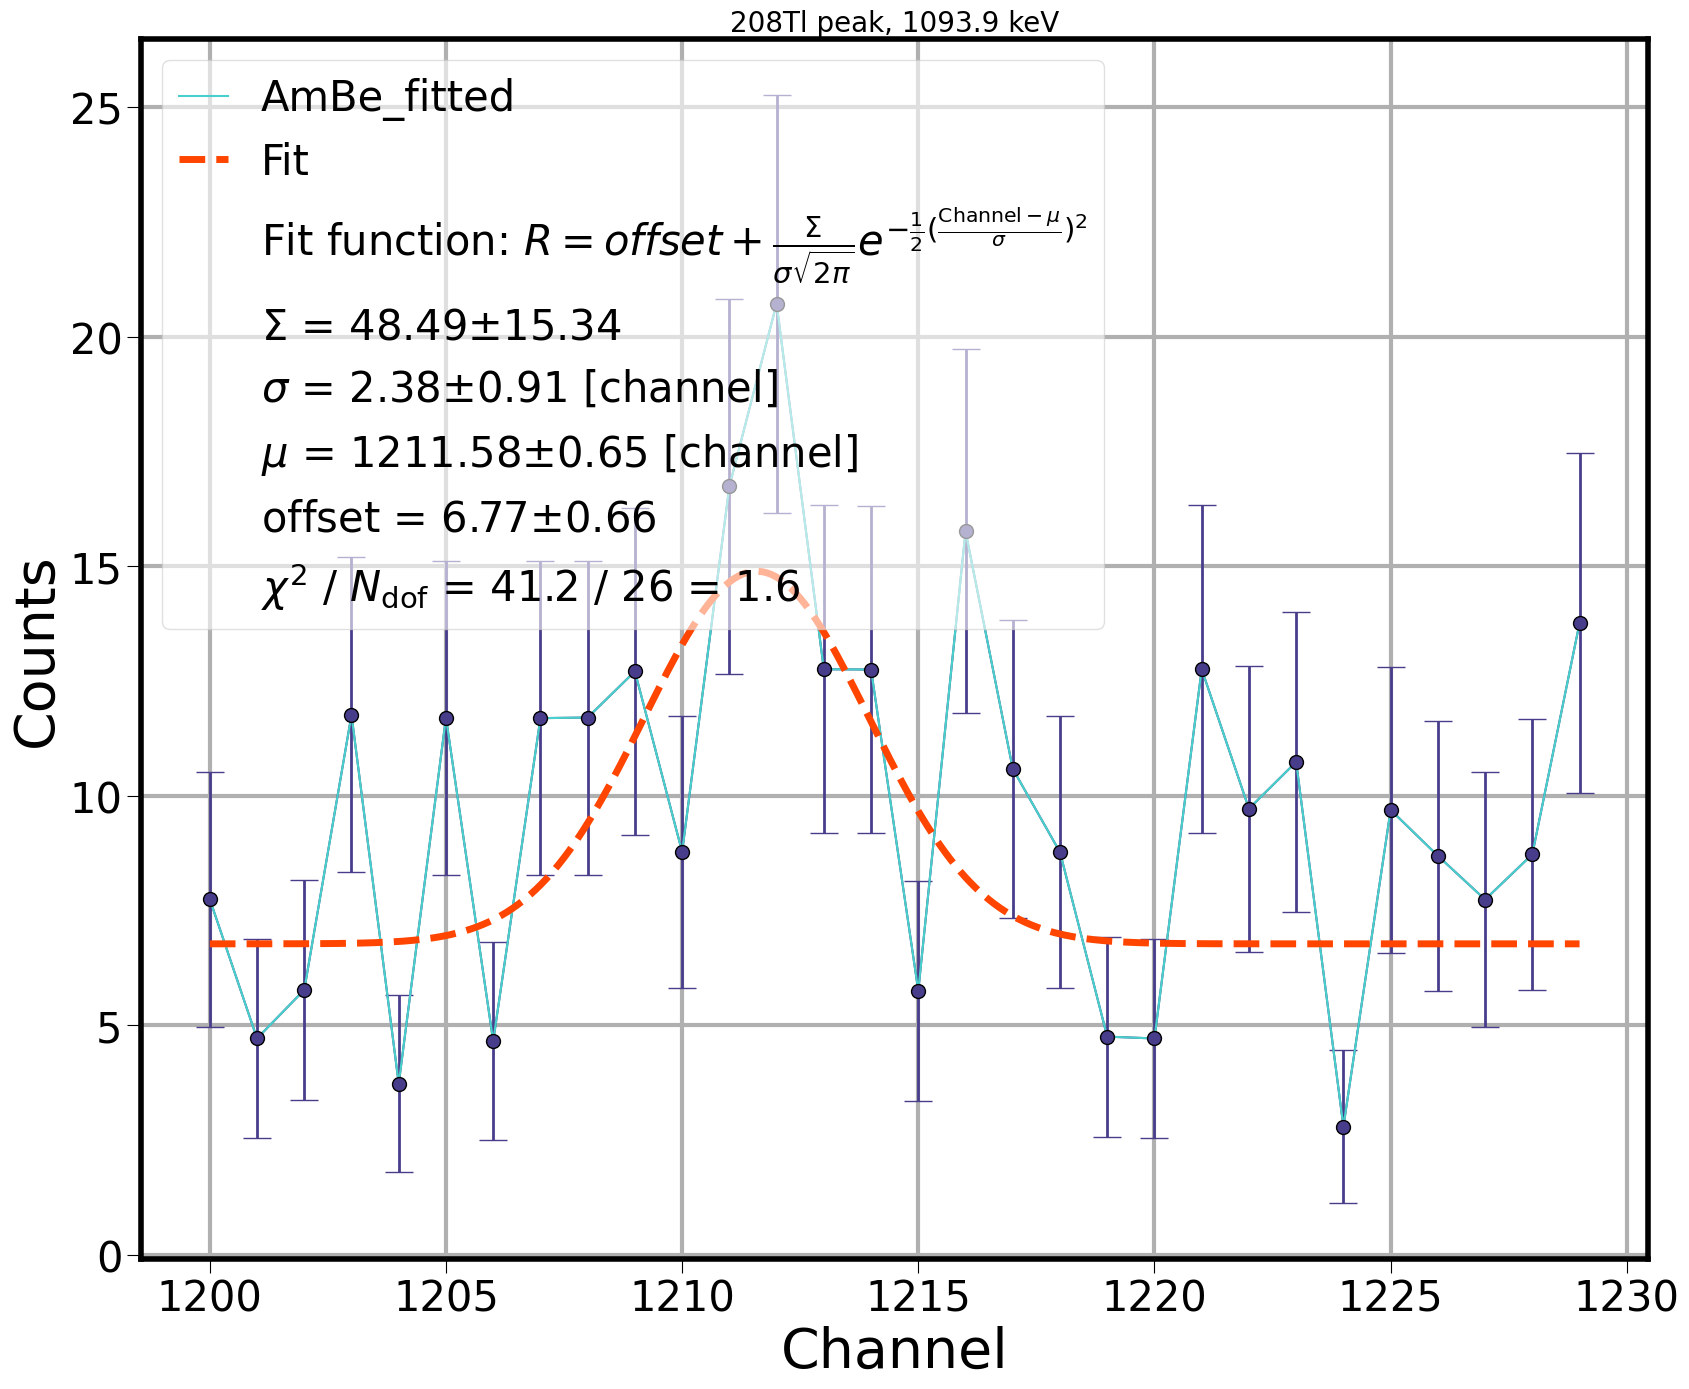

In [18]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1200
ch2=1230
ch3=1200
ch4=1230

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1210
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1512.7 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.42 (χ²/ndof = 1.0)      │              Nfcn = 138              │
│ EDM = 1.16e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    199    │    16     │            │            │         │         │       │
│ 1 │ sig    │   1.73    │   0.14    │            │            │         │         │       │
│ 2 │ mu     │ 1.61829e3 │ 0.00015e3 │            │            │         │         │       │
│ 3 │ offset │    5.5    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    268  0.586  0.007  -1.40 │
│    sig │  0.586 0.0195  0.001 -0.012 │
│     mu │  0.007  0.001 0.0237 -0.000 │
│ offset │  -1.40 -0.012 -0.000  0.137 │
└────────┴─────────────────────────────┘

<ValueView A=198.53375668654243 sig=1.732728308579857 mu=1618.29133861141 offset=5.455441685986401>
<ErrorView A=16.381545488010044 sig=0.13951362602965817 mu=0.15401142013811858 offset=0.3702118454271331>
(198.53375668654243, 1.732728308579857, 1618.29133861141, 5.455441685986401)


/tmp/ipykernel_5968/4176853287.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e222440> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/4176853287.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/4176853287.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2e222440> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

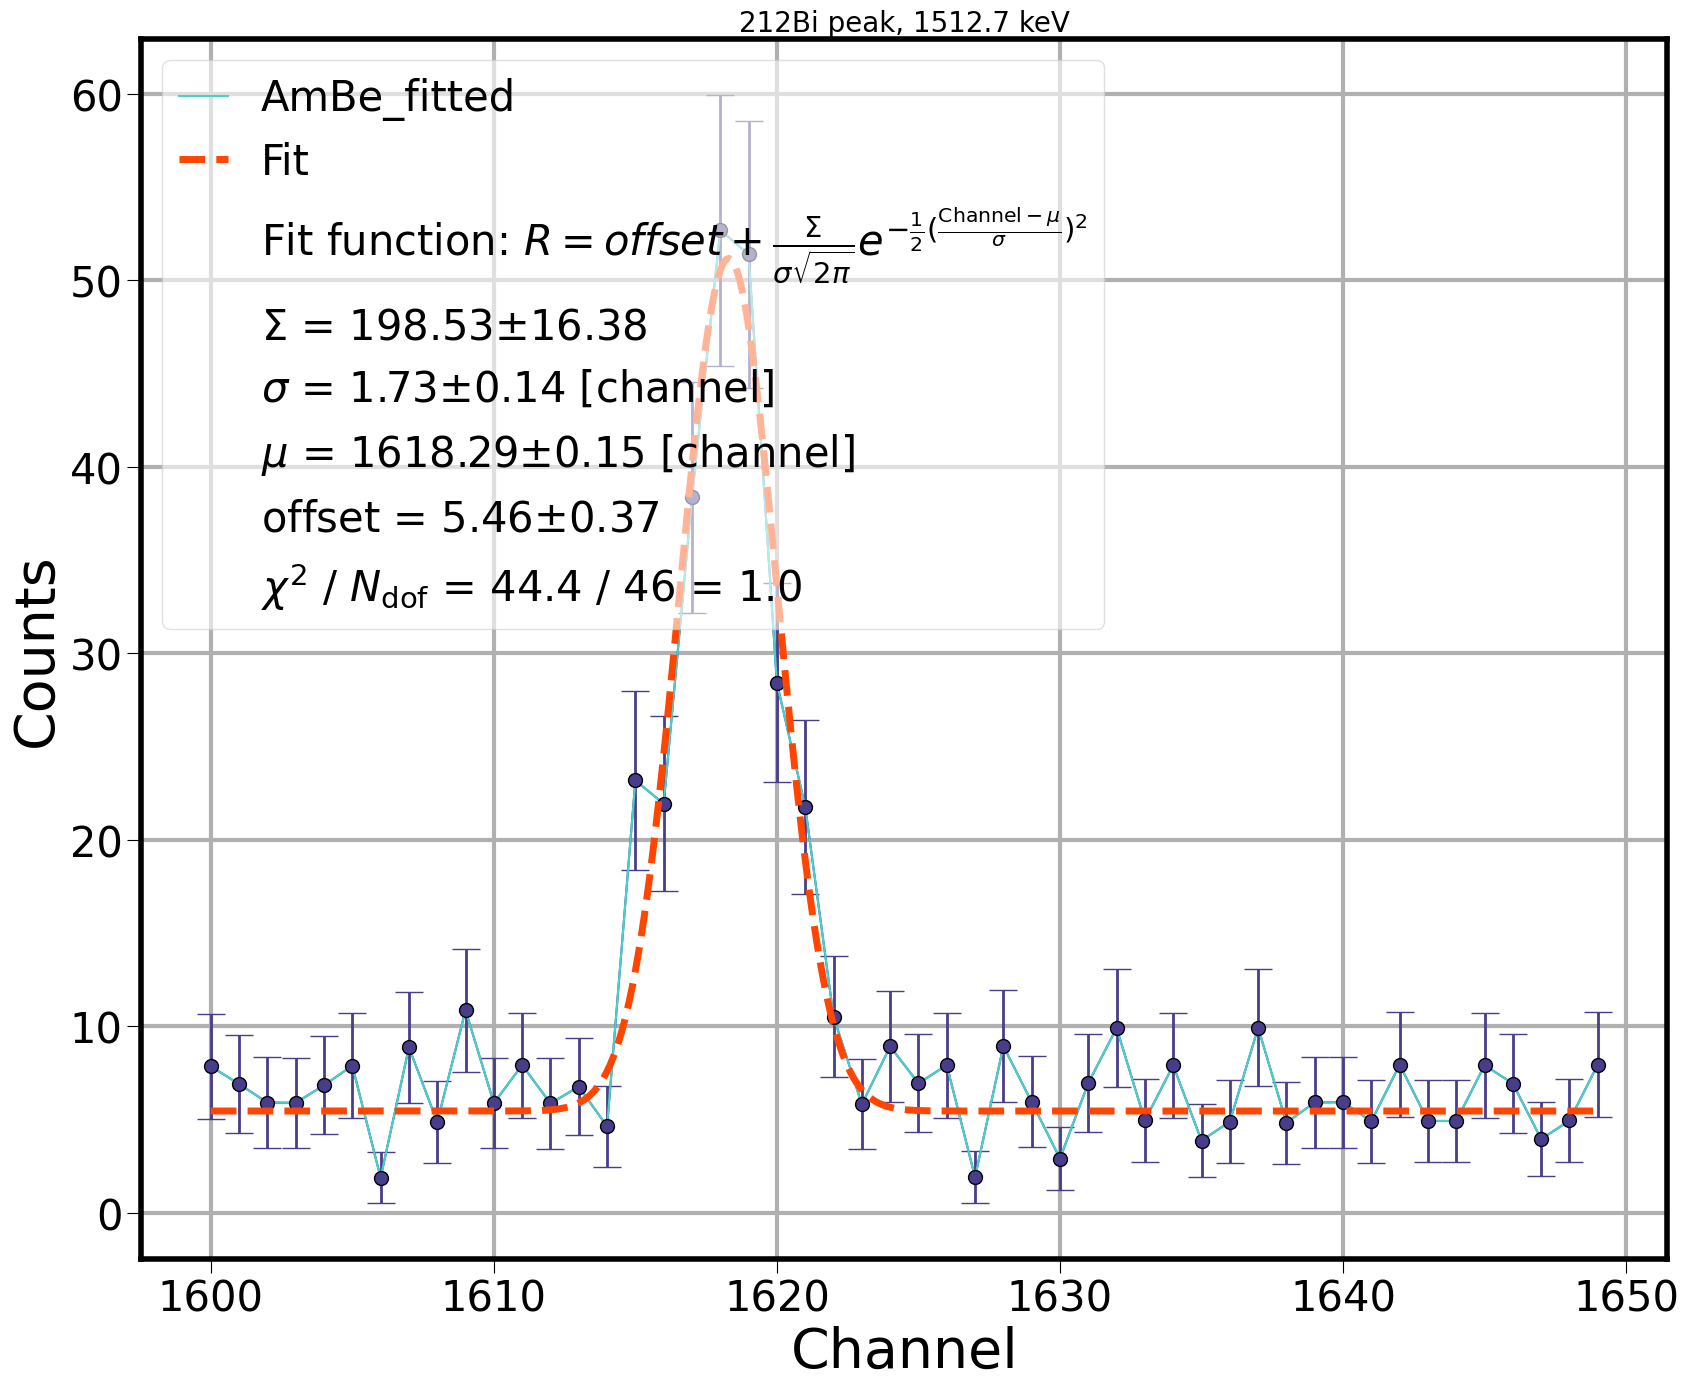

In [19]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1600
ch2=1650
ch3=1600
ch4=1650

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1620
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1592.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.5 (χ²/ndof = 1.1)       │              Nfcn = 363              │
│ EDM = 1.7e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    202    │    17     │            │            │         │         │       │
│ 1 │ sig    │   2.10    │   0.18    │            │            │         │         │       │
│ 2 │ mu     │ 1.76311e3 │ 0.00019e3 │            │            │         │         │       │
│ 3 │ offset │    5.3    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    294  0.915  0.029  -2.30 │
│    sig │  0.915 0.0331  0.001 -0.023 │
│     mu │  0.029  0.001 0.0351 -0.001 │
│ offset │  -2.30 -0.023 -0.001   0.19 │
└────────┴─────────────────────────────┘

<ValueView A=202.28415118597684 sig=2.104536310269804 mu=1763.1079487177701 offset=5.300577682704937>
<ErrorView A=17.15952692116392 sig=0.18198377062557355 mu=0.18734639154337396 offset=0.4359786432786645>
(202.28415118597684, 2.104536310269804, 1763.1079487177701, 5.300577682704937)


/tmp/ipykernel_5968/3614923169.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31f750c0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/3614923169.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/3614923169.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31f750c0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

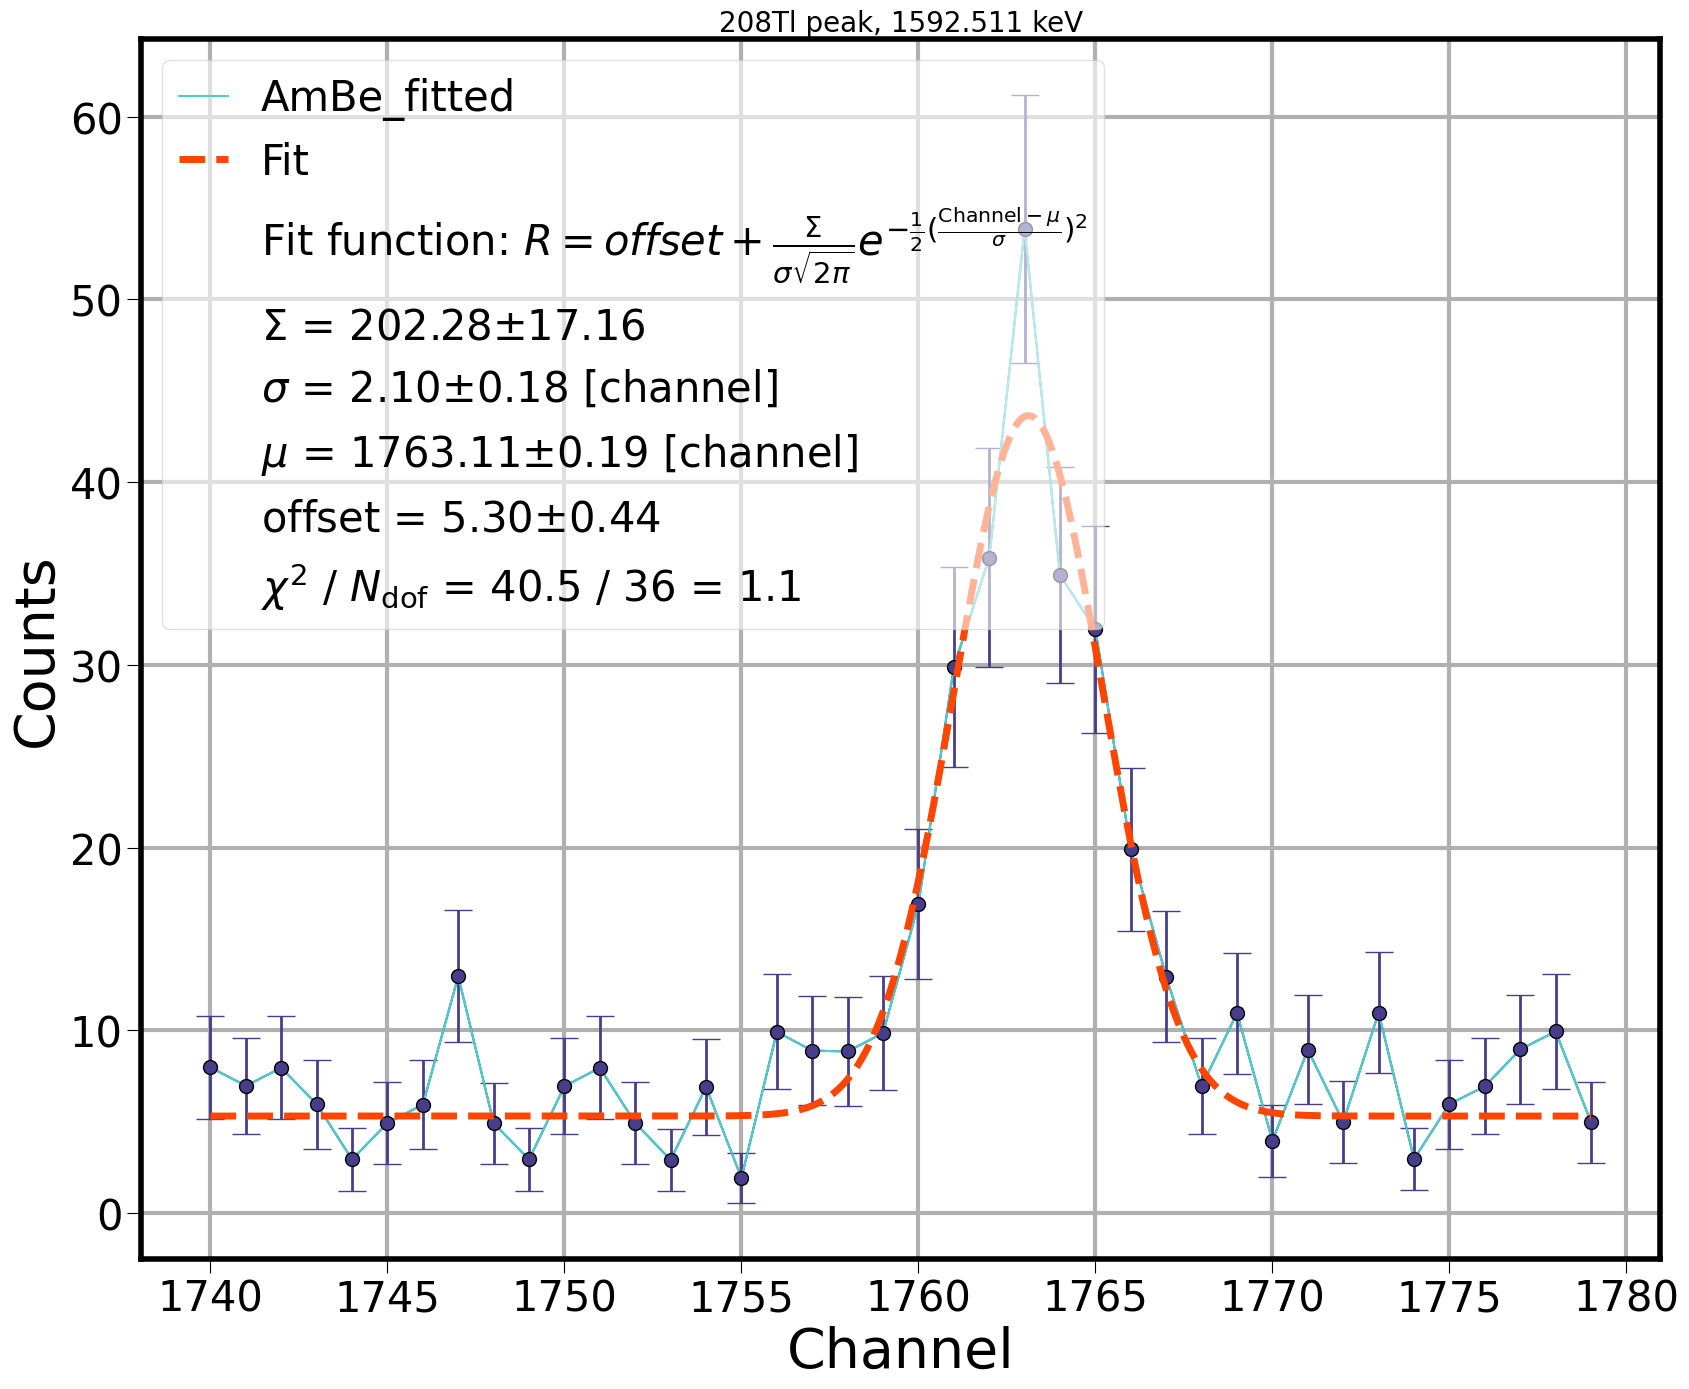

In [20]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1740
ch2=1780
ch3=1740
ch4=1780

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1760
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1620.5 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.42 (χ²/ndof = 1.1)      │              Nfcn = 130              │
│ EDM = 8.65e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    288    │    20     │            │            │         │         │       │
│ 1 │ sig    │   1.85    │   0.11    │            │            │         │         │       │
│ 2 │ mu     │ 1.79523e3 │ 0.00014e3 │            │            │         │         │       │
│ 3 │ offset │    6.8    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    400  0.601  0.036  -3.75 │
│    sig │  0.601 0.0126  0.001 -0.020 │
│     mu │  0.036  0.001 0.0184 -0.001 │
│ offset │  -3.75 -0.020 -0.001   0.35 │
└────────┴─────────────────────────────┘

<ValueView A=287.71347989346884 sig=1.848700882667696 mu=1795.2278568015722 offset=6.75638572300305>
<ErrorView A=19.999585453151198 sig=0.1120275038385253 mu=0.13578303112386286 offset=0.5918666770674542>
(287.71347989346884, 1.848700882667696, 1795.2278568015722, 6.75638572300305)


/tmp/ipykernel_5968/2526975435.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31953760> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/2526975435.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/2526975435.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf31953760> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

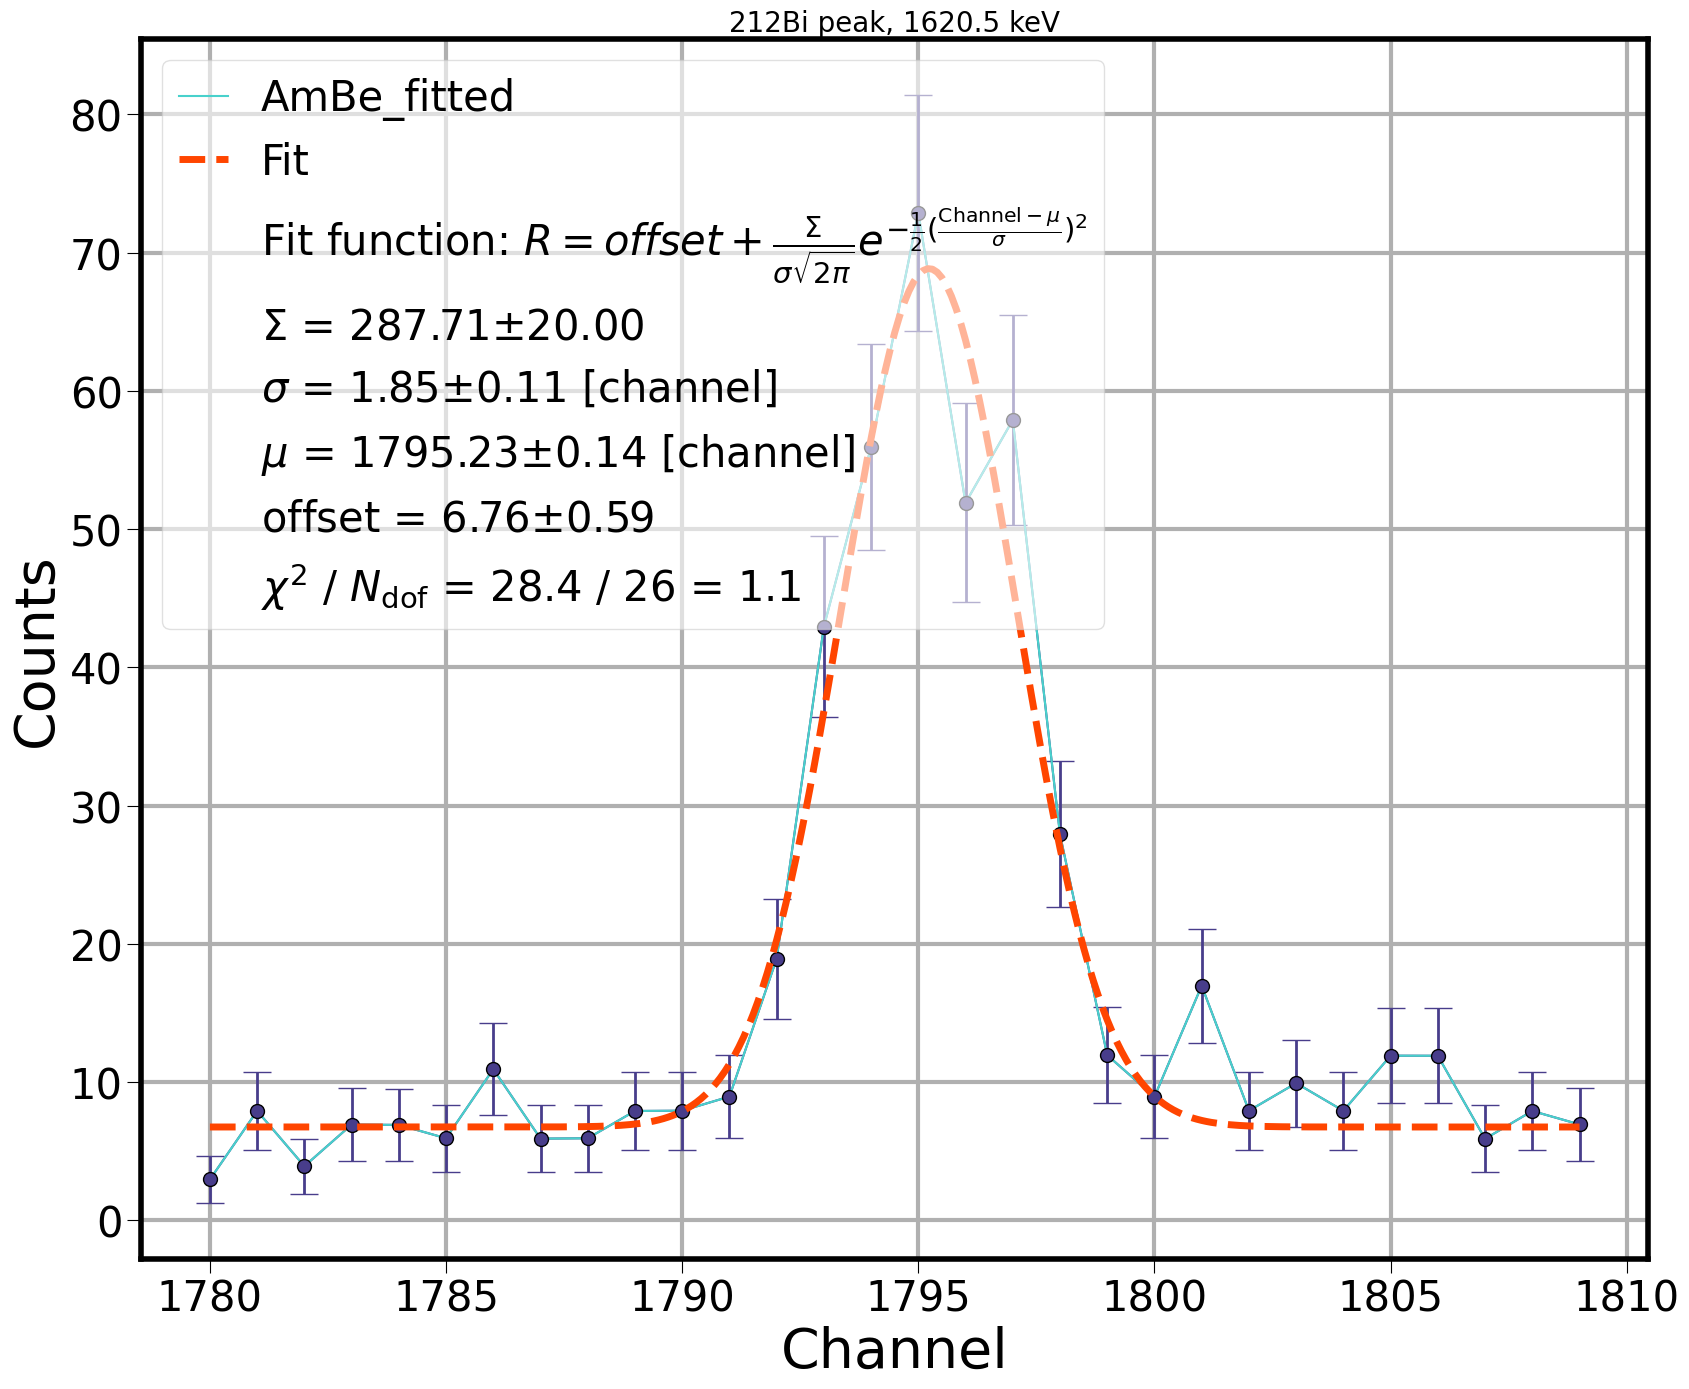

In [21]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1780
ch2=1810
ch3=1780
ch4=1810

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1790
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl SE peak, 2103.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 54.35 (χ²/ndof = 1.2)      │              Nfcn = 143              │
│ EDM = 5.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    564    │    28     │            │            │         │         │       │
│ 1 │ sig    │   2.21    │   0.11    │            │            │         │         │       │
│ 2 │ mu     │ 2.32895e3 │ 0.00012e3 │            │            │         │         │       │
│ 3 │ offset │   10.5    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    767  0.748 -0.069  -4.19 │
│    sig │  0.748 0.0119 -0.003 -0.015 │
│     mu │ -0.069 -0.003 0.0135  0.001 │
│ offset │  -4.19 -0.015  0.001  0.298 │
└────────┴─────────────────────────────┘

<ValueView A=564.2675584139006 sig=2.210233488548203 mu=2328.9540756712995 offset=10.510019405485405>
<ErrorView A=27.69988384324063 sig=0.10897765123959532 mu=0.11625960457629164 offset=0.5455257343512495>
(564.2675584139006, 2.210233488548203, 2328.9540756712995, 10.510019405485405)


/tmp/ipykernel_5968/1610654821.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2ec03fd0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_5968/1610654821.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5968/1610654821.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fdf2ec03fd0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

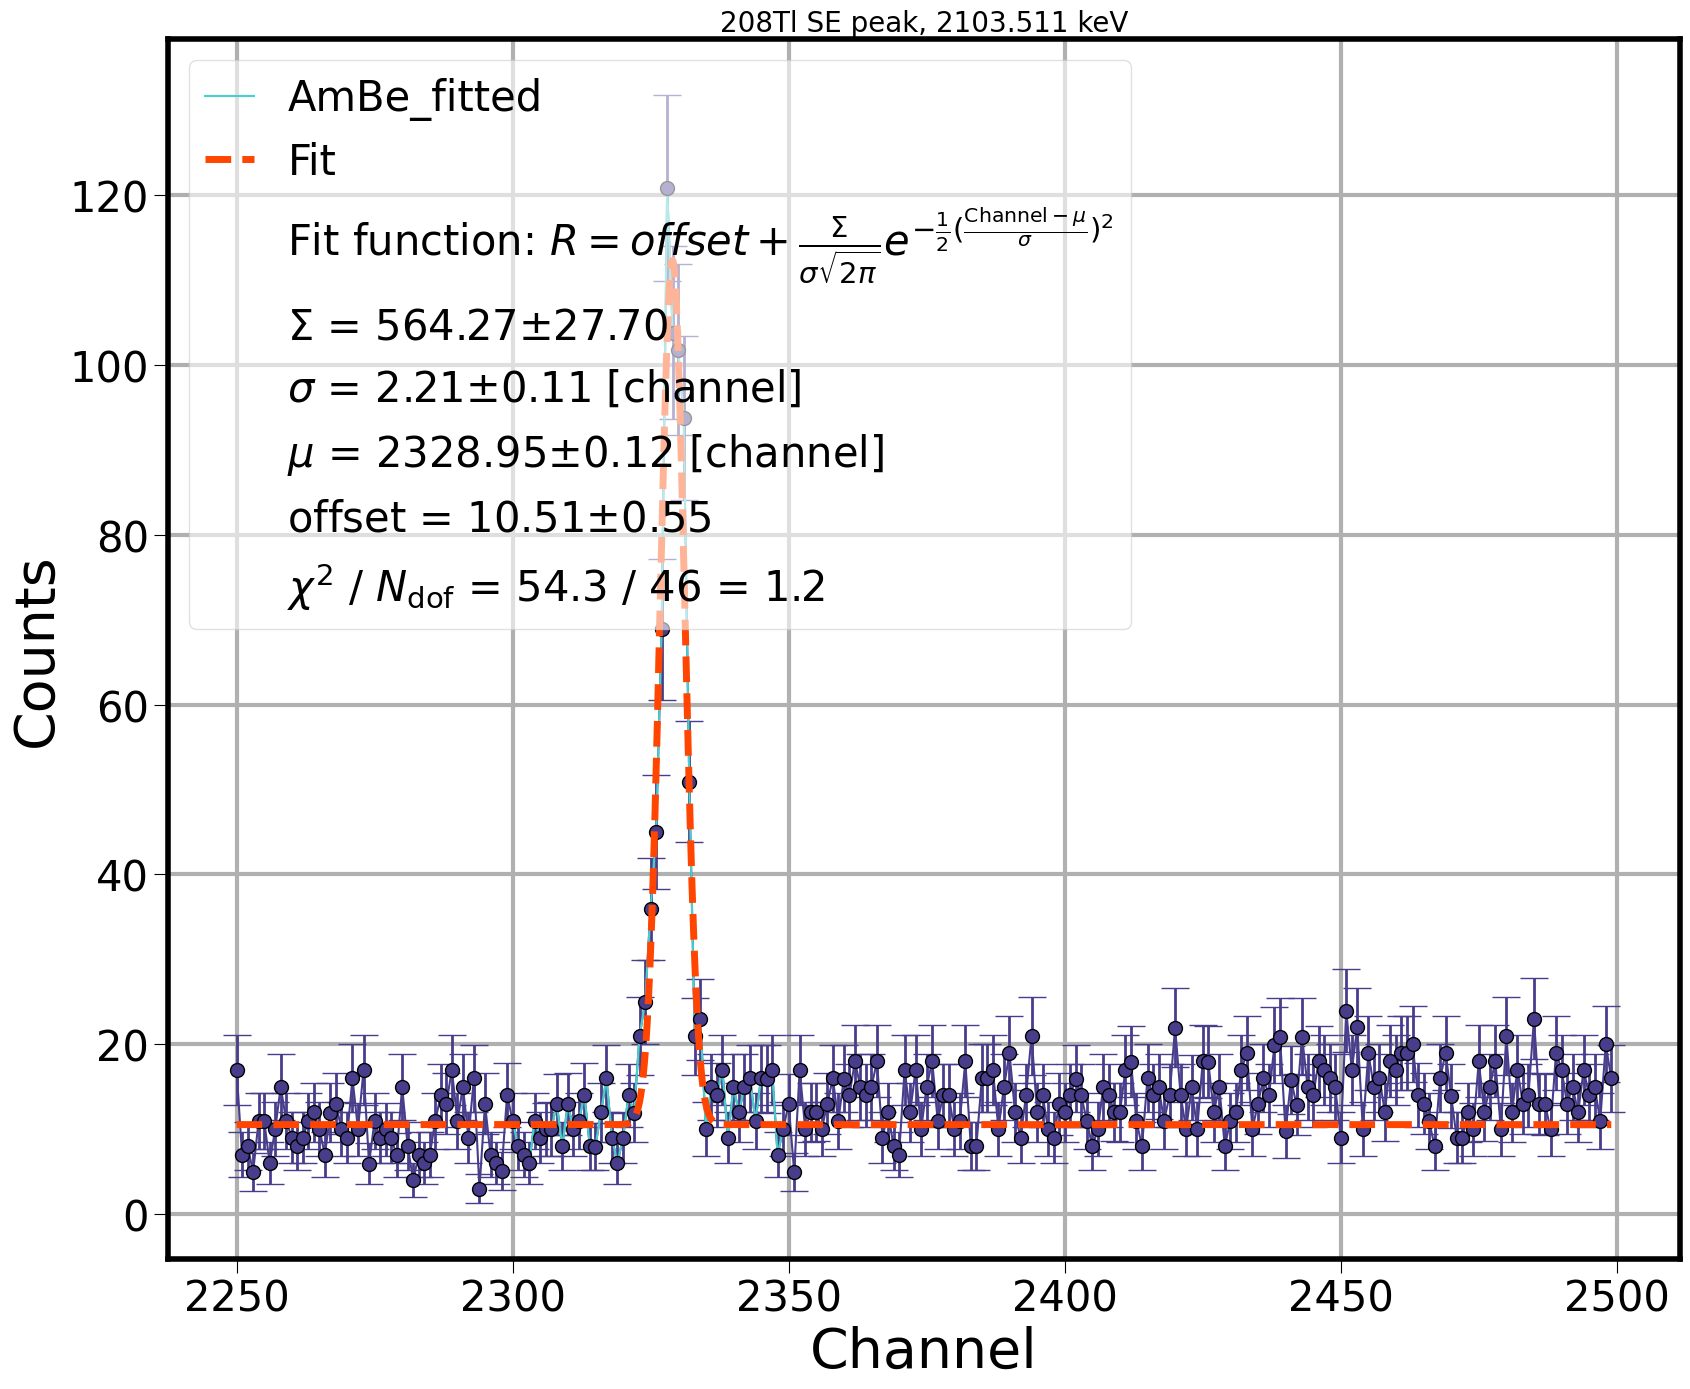

In [22]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=2300
ch2=2350
ch3=2250
ch4=2500

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 4000
mu00 = 2325
sig00 = 2 
offset00 = 0

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


In [23]:
popindex=[13,2]
print(Peak_energy)
for pi in popindex:
    Peak_name.pop(pi)
    Peak_energy.pop(pi) 
    Peak_channel.pop(pi)
    Peak_channel_err.pop(pi)
    Sigma_channel.pop(pi)
    Sigma_channel_err.pop(pi)
    print(Peak_energy)



[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]


'212Bi'

1512.7

1618.29133861141

0.15401142013811858

1.732728308579857

0.13951362602965817

[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


'212Bi'

288.2

319.9313726595933

0.6234260846690467

1.9002197977283695

1.0165358477734054

[115.183, 277.371, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th energy calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Channel')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 109.5 (χ²/ndof = 8.4)      │              Nfcn = 35               │
│ EDM = 1.24e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   1.137   │   0.033   │            │            │         │         │       │
│ 1 │ p1   │  1.10690  │  0.00005  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │    0.00108 -1.5709e-6 │
│ p1 │ -1.5709e-6   2.57e-09 │
└────┴───────────────────────┘

<ValueView p0=1.1373738969808764 p1=1.1068965485819264>
<ErrorView p0=0.032826456114288534 p1=5.0704014018119444e-05>
(1.1373738969808764, 1.1068965485819264)


/tmp/ipykernel_5968/3831346235.py:207: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

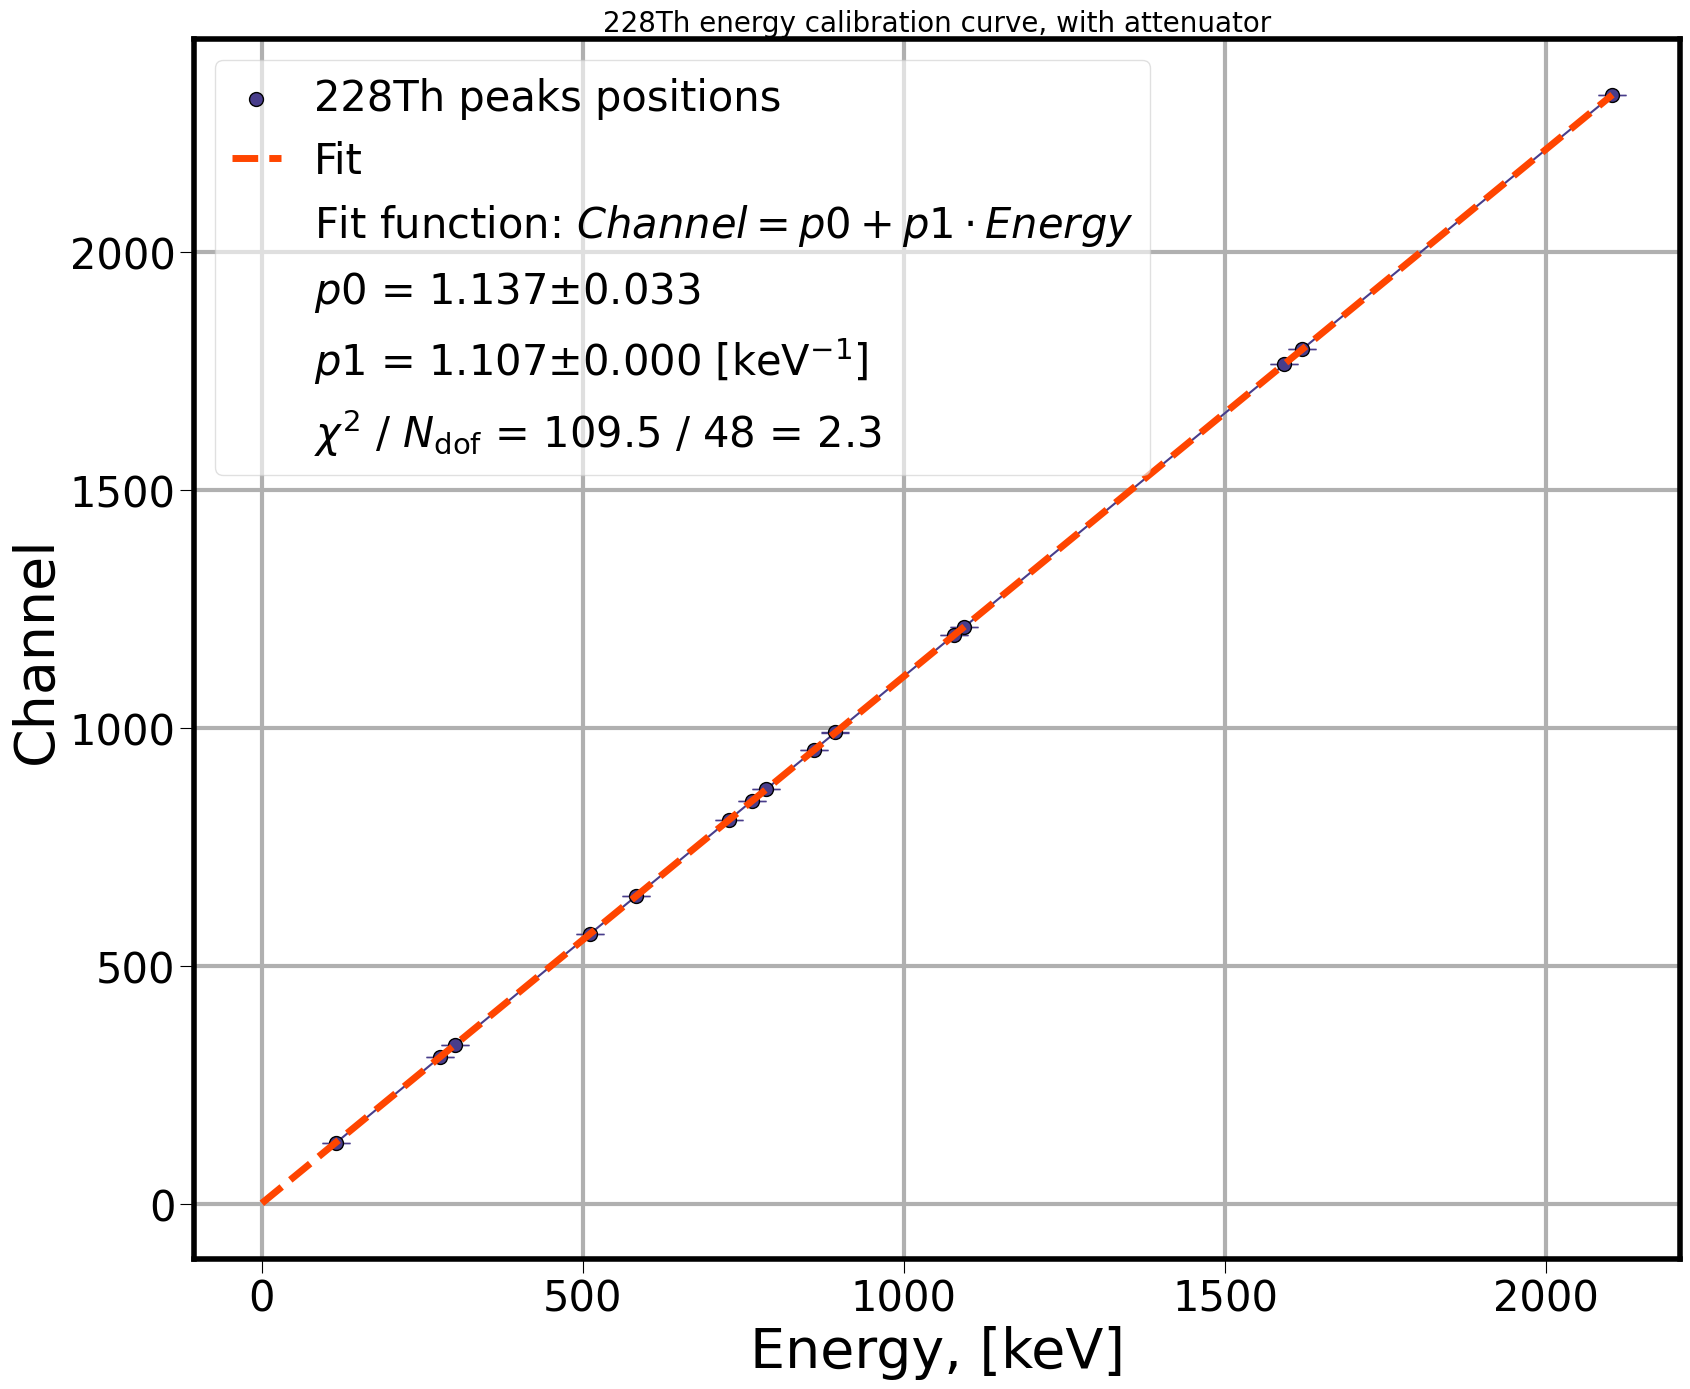

In [24]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th energy calibration curve, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Channel", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()












handlelist=[]
labellist=[]


Data, = ax1.plot(Peak_energy, Peak_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Peak_channel, yerr=Peak_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Peak_channel, label=r'228Th peaks positions', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(data)
labellist.append(data.get_label())







#define fit function
def linear(x, p0, p1):
    return p0+p1*x





#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Peak_channel, Peak_channel_err,linear)




#set initial parameter values
p00=1.234
p10=1.1



#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p1']),number_sigdigs(minuit.errors['p1'])), 
                                        round(Decimal(minuit.errors['p1']),number_sigdigs(minuit.errors['p1'])))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration.png", bbox_inches ='tight')
plt.show()


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th resolution calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Sigma, [Channel]')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.92 (χ²/ndof = 3.5)      │              Nfcn = 33               │
│ EDM = 1.67e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   1.218   │   0.029   │            │            │         │         │       │
│ 1 │ p1   │  0.36e-3  │  0.05e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │   0.000864 -1.2882e-6 │
│ p1 │ -1.2882e-6    2.1e-09 │
└────┴───────────────────────┘

<ValueView p0=1.2181233564104277 p1=0.00036258537347328996>
<ErrorView p0=0.029401118643535597 p1=4.5869500736522055e-05>
(1.2181233564104277, 0.00036258537347328996)


/tmp/ipykernel_5968/1821186506.py:206: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

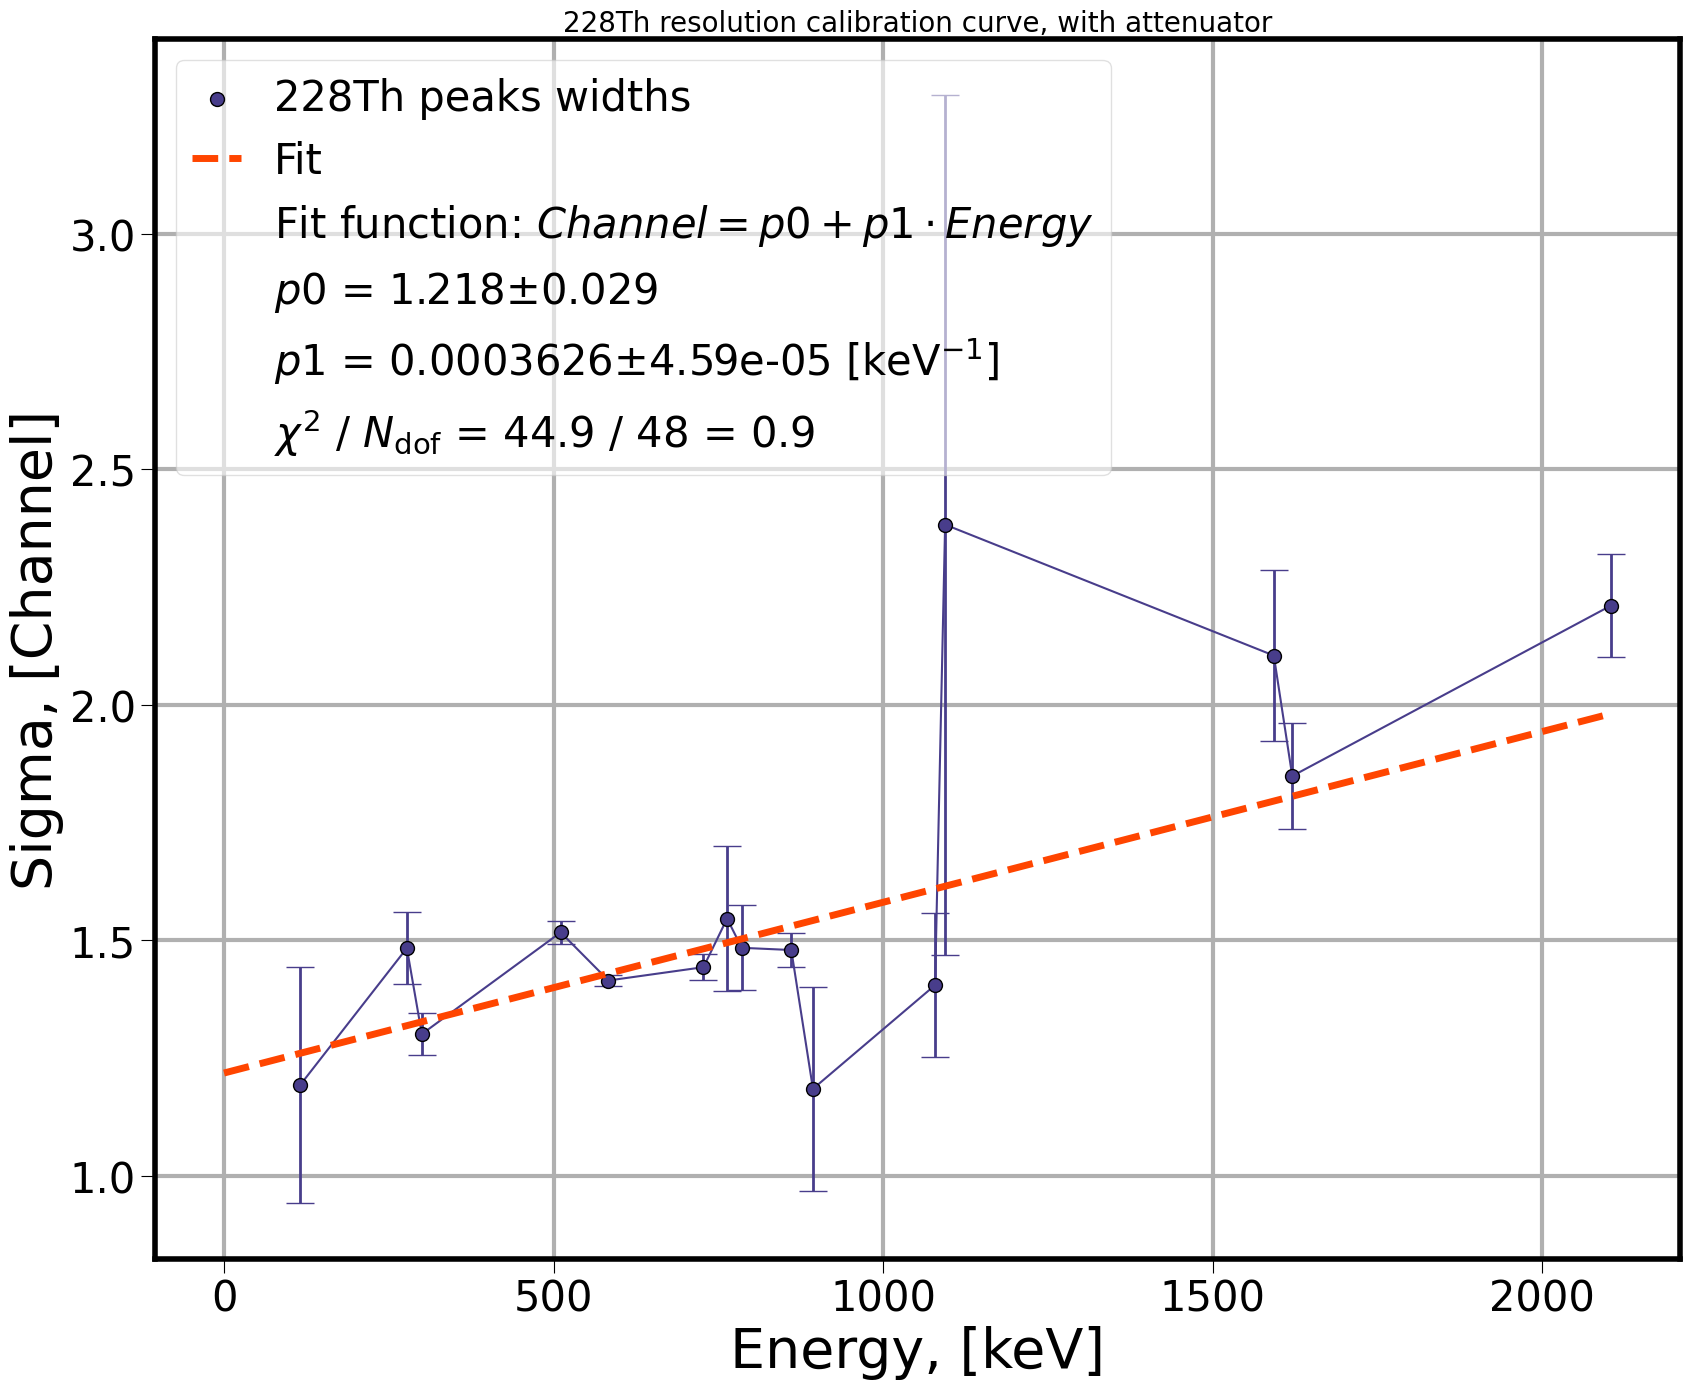

In [25]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th resolution calibration curve, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Sigma, [Channel]", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()












handlelist=[]
labellist=[]


Data, = ax1.plot(Peak_energy, Sigma_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Sigma_channel, yerr=Sigma_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Sigma_channel, label=r'228Th peaks widths', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(data)
labellist.append(data.get_label())







#define fit function
def linear(x, p0, p1):
    return p0+p1*x





#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Sigma_channel, Sigma_channel_err,linear)




#set initial parameter values
p00=-0.41
p10=0.003



#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}'.format(round(minuit.values['p1'],7), round(minuit.errors['p1'],7))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration_sigma.png", bbox_inches ='tight')
plt.show()
